#### Advanced Lane Finding Project
##### The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients k1 k2 and k3--> using chessboard images.
* Now undistor the images to get the real world dimensions.
* Use the advantages of color space HLS and Sobel operator. Combine the best of both to figure out the lane lines andcreate a thresholded binary image.
* Execute a perspective transform ont hte binary images to get a ("birds-eye view") and make the remeining steps like detect lane line and fit a 2d polynomial easier.
* Detect pixels of the lane line with slipping window method
* Fit a polynomial to calculate the curvature of the lane and to get vehicle position with respect to center.
* Transform the detected lane lines from the warped image (bird eye view) back into a unwarped undistorted imageack into the
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [230]:
#  Initialize the enviraonment conditions for etect lane lines
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import pickle
import os
from scipy.stats.stats import pearsonr
from skimage import color


left_fitx_old = None
right_fitx_old = None
leftx_base_old = None
rightx_base_old = None

detected = False
leftx_old = None
lefty_old = None
rightx_old = None
righty_old = None

left_fit_old = None
right_fit_old = None

# path for output examples of the several steps
image_path = 'output_images/chessboard_corners/'
image_path_undistorted_images = 'output_images/'

# path from test images
img_dir = 'test_images/'
images = os.listdir(img_dir)

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

### Helper function

In [2]:
# define pickle to save the distoriton coefficients k1,k1 and k3 'dist' and the camera matrix as 'mtx'
def pickle_dump(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def pickle_load():
    # Getting back the camera calibration result:
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']
    
def draw_and_save_image(path, name, plot=False,save= False):
    # Draw the plot
    if plot:
        plt.imshow(img)
        plt.show()
    # Save to the file
    if save:
        write_name = name + '.jpg'
        cv2.imwrite(str(path) + write_name,img)
    return

# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
            

### Execute the Camera calibration with the calibration images

In [3]:
#Calculate the 3d and 2d points for preparing the camera calibration
def find2D3DCorners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('Num of calibration images: {0}'.format(len(images)))
    print('Watching the images in the:',path)
    
    # Step through the list and search for chessboard corners
    for img_id, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # draw and save depending on given arguments and pathes
            draw_and_save_image(image_path, 'chesboard_corners'+ str(img_id),plot=True,save=True)
            
    return objpoints, imgpoints

In [4]:
# Calibrate the camero using the find2D3DCorners and cv2.calibrateCamera
# returns the mtx=camera matrix for tranfer 3d into 2d,dis=distortion coefficients
# In this project we will ignore the rvecs=rotation Vectors, tvecs=translationVectors
# This step have to be done only once in the project for getting mtx and dist of the calibration images
def calibrate_camera(img):
    img_size = (img.shape[1], img.shape[0])
    # Claculate the 2d and 3d object point 
    objpoints, imgpoints = find2D3DCorners()
    # Calculate the camera matrix dist=distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Save the camera ntx and dist to pickle data set
    pickle_dump(mtx, dist)
    print('CALIBRATION DONE')
    return mtx, dist

# execute calibration step
mtx, dist = calibrate_camera(img)


NameError: name 'img' is not defined

### Color Threshold and Gradient Threshold

#### Gradient Threshold Methods with

In [167]:
# Apply Sobel directional gradient and apply gradient threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take s-channel of HLS color space
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Calculate the derivative. That depends on argument orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Calc absolute gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return masked image as the binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobel_y, abs_sobimg_transel_x) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [218]:
def combinedGradientThresholds(img, do_plot=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(65, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(65, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.1, 1.0))    
    
    
    #f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(grad_x_binary,cmap='gray')
    #ax1.set_title('grad_x_binary', fontsize=50)
    #ax2.imshow(grad_y_binary,cmap='gray')
    #ax2.set_title('grad_y_binary', fontsize=50)
    #ax3.imshow(mag_binary,cmap='gray')
    #ax3.set_title('mag_binary', fontsize=50)
    ##ax4.imshow(dir_binary,cmap='gray')
    ##ax4.set_title('dir_binary', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Combine the thresholds
    combined = np.zeros_like(grad_x_binary)
    combined[((grad_x_binary == 1)&(mag_binary ==1)&(grad_y_binary == 1)) | ((grad_x_binary == 1) & (mag_binary ==1))| (grad_x_binary == 1) ] = 1
    
    # Return the best of Gradient Threshold
    return combined

#### Color Threshold Methods

In [219]:
# combine the best out of two worös color and gradient threshold methods
def combinedColorSpaceThresholds(img, thresh=(0, 255)):
    
    # Convert to HLS color space and separate the S channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Color Space B from LAB
    lab = color.rgb2lab(img)
    b_channel = lab[:,:,2] 
    b_thresh_min = 25
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Color Space B from LAB
    luv = color.rgb2luv(img)
    l_channel = luv[:,:,0] 
    l_thresh_min = 85
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    
        
    return l_binary, b_binary, s_binary

#### Combine Color Threshold and Gradient Threshold

In [227]:
def combineColorAndGradientThresholds(image):
    # Perform Sobel operations and combine thresholds
    combinedGradientSobel = combinedGradientThresholds(image)
    #plot_row2(image, combinedGradientSobel, 'undistorted' ,'Sobel Combined Gradients', graysc=True)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(image)
    #ax1.set_title('image', fontsize=50)
    #ax2.imshow(combinedGradientSobel,cmap='gray')
    #ax2.set_title('combinedGradientSobel', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #
    # Threshold color channel
    #combinedColorThresholds = combinedColorSpaceThresholds(image, thresh=(160, 255))
    l_binary, b_binary, s_binary = combinedColorSpaceThresholds(image, thresh=(180, 255))
    #plot_row2(image, combinedColorThresholds, 'undistorted' ,'Color Threshold', graysc=True)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) & (b_binary == 1))|((l_binary == 1)&(s_binary == 1))|((l_binary == 1)|(b_binary == 1))] = 1
    #f, (ax1, ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(l_binary,cmap='gray')
    #ax1.set_title('l_binary', fontsize=50)
    #ax2.imshow(s_binary,cmap='gray')
    #ax2.set_title('s_binary', fontsize=50)
    #ax3.imshow(b_binary,cmap='gray')
    #ax3.set_title('b_binary', fontsize=50)
    #ax4.imshow(combined_binary,cmap='gray')
    #ax4.set_title('combined_binary', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Combine color and gradient thresholds
    combinedThresholdsBinaryImage = np.zeros_like(combinedGradientSobel)
    #combinedThresholdsBinaryImage[(combinedGradientSobel == 1) | (combinedColorThresholds == 1)] = 1
    #combinedThresholdsBinaryImage[((combinedGradientSobel == 1) | (l_binary == 1))&((combinedGradientSobel == 1) | (s_binary == 1))&((combinedGradientSobel == 1) | (b_binary == 1))] = 1
    combinedThresholdsBinaryImage[(combined_binary==1) | (combinedGradientSobel == 1)]=1
    #plot_row2(image, combinedThresholdsBinaryImage, 'undistorted' ,'Color and Sobel Combined Threshold', graysc=True)

    
    
    return combinedThresholdsBinaryImage

In [222]:
# Practical approach to define src and dst point in the original and output image
def calcSrcAndDstPoints(img):
    
    #Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    
    return src,dst

In [234]:
# Implement Sliding Windows and Fit a Polynomial
def slidingWindowMethod (binary_warped, leftx_base, rightx_base):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    
    
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binary_warped,left_fit,right_fit)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binary_warped)
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(out_img)
    #ax2.set_title('out_img', fontsize=50)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
           
    

    
    
    #return out_img,ploty,leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx,
    return out_img,leftx, lefty, rightx, righty

In [31]:
def polynomFit2nd(lefty, leftx, righty, rightx):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit

In [12]:
def genrateValuesXYforPlot(binary_warped,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx,ploty

In [13]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [14]:
def sanityCheck(left_fitx,right_fitx,threshold=0.85):
    global left_fitx_old
    global right_fitx_old
    global detected
    
    if (left_fitx_old == None):
        left_fitx_old = left_fitx
                
    if (right_fitx_old == None):
        right_fitx_old = right_fitx
        
   
    ret_left = pearsonr(left_fitx_old, left_fitx)
    ret_right = pearsonr(right_fitx_old, right_fitx)
    
    if (ret_left[0] > threshold):
        left_fitx_old = left_fitx
        detected = True
    else:
        left_fitx = left_fitx_old
        detected = False
    
    if (ret_right[0] > threshold):
        right_fitx_old = right_fitx
        detected = True
    else:
        right_fitx = right_fitx_old
        detected = False
        
    return left_fitx, right_fitx, detected

In [235]:
  
def main(img):
    # Load calibration data generated in calibrate_camera
    mtx, dist = pickle_load()
    # Calculate the undistorted image
    image_undistored = cv2.undistort(img, mtx, dist, None, mtx)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(image_undistored)
    #ax2.set_title('Undistorted Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Calculate combined binaryImage based on a mix of both
    # combinedColorThresholds and combinedSobelGradient threshold methods
    combinedThresholdsBinaryImage = combineColorAndGradientThresholds(image_undistored)    # define source_img and destination_img point for preparing the perspective transform
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(image_undistored)
    #ax1.set_title('image_undistored', fontsize=50)
    #ax2.imshow(combinedThresholdsBinaryImage, cmap ='gray')
    #ax2.set_title('combinedThresholdsBinaryImage', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    # using cv2.findChessboardCorners
    src, dst = calcSrcAndDstPoints(combinedThresholdsBinaryImage)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    img_size = (combinedThresholdsBinaryImage.shape[1], combinedThresholdsBinaryImage.shape[0])
    binary_warped = cv2.warpPerspective(combinedThresholdsBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)    
    
   
    
    
    # Define image mask (polygon of interest)
    binaryWarpedImageShape = binary_warped.shape
    vertices = np.array([[(200, binaryWarpedImageShape[0]), (200, 0), (binaryWarpedImageShape[1] - 200, 0), 
                      (binaryWarpedImageShape[1]-200, binaryWarpedImageShape[0])]], dtype=np.int32)
    binaryWarpedMaskedImage = region_of_interest(binary_warped, vertices)
    
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binary_warped, cmap ='gray')
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(binaryWarpedMaskedImage, cmap ='gray')
    #ax2.set_title('binaryWarpedMaskedImage', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
   
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
    car_pos = binary_warped.shape[1] / 2
    deviation = int(abs(mid_of_lane - car_pos) * (3.7 / 700) * 100)  

    global detected
    global leftx_base_old
    global rightx_base_old
    global left_fit_old 
    global right_fit_old
    global leftx_old
    global lefty_old
    global rightx_old
    global righty_old
    #print("before", abs(leftx_base - rightx_base))
    
    if (leftx_base_old == None):
        leftx_base_old = leftx_base
        
    if (rightx_base_old == None):
        rightx_base_old = rightx_base
    if (abs(leftx_base - rightx_base) < 250) & (abs(leftx_base - rightx_base) > 160):
        leftx_base_old = leftx_base
        rightx_base_old = rightx_base
    else:
        leftx_base = leftx_base_old
        rightx_base = rightx_base_old
    print('this is the state before choosing window method',detected)

    #if (detected == False):
    #    out_img,leftx, lefty, rightx, righty = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    #    if (len(leftx) < 1500):
    #        leftx = leftx_old 
    #        lefty = lefty_old
    #        detected == False
    #    else:
    #        leftx_old = leftx
    #        lefty_old = lefty
#
    #    if (len(rightx) < 1500):
    #        rightx = rightx_old
    #        righty = righty_old
    #        detected == False
    #    else:
    #        rightx_old = rightx
    #        righty_old = righty
    #        
#
    #    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #    left_fit_old = left_fit
    #    right_fit_old = right_fit
    #    
    #if (detected == True):    
    #    out_img,leftx, lefty, rightx, righty = lookAheadFilter(left_fit_old, right_fit_old, binaryWarpedMaskedImage)
    #    if (len(leftx) < 1500):
    #        leftx = leftx_old 
    #        lefty = lefty_old
    #        detected == False
    #    else:
    #        leftx_old = leftx
    #        lefty_old = lefty
#
    #    if (len(rightx) < 1500):
    #        rightx = rightx_old
    #        righty = righty_old
    #        detected == False
    #    else:
    #        rightx_old = rightx
    #        righty_old = righty
    #        
    #    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #    left_fit_old = left_fit
    #    right_fit_old = right_fit        
    #
    out_img,leftx, lefty, rightx, righty = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binaryWarpedMaskedImage,left_fit,right_fit)
    print('this is the state after generate XY values',detected)

    #left_fitx, right_fitx, detected = sanityCheck(left_fitx, right_fitx)
    
    
    
    print('this is the state',detected)
    
   

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binaryWarpedMaskedImage, cmap ='gray')
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(out_img,cmap ='gray')
    #ax2.set_title('out_img', fontsize=50)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #       
    
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curveradMeter, right_curveradMeter = convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty)
    
    #Compute the inverse perspective transform to unwarped the image
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    finalOutputImage = drawPolynomialsBackIntoOriginalImage(binaryWarpedMaskedImage,image_undistored, out_img, left_fitx, right_fitx, left_curveradMeter, right_curveradMeter,deviation, ploty, Minv)
    
    return finalOutputImage
    

In [26]:
# LOOK AHEAD FILTER
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def lookAheadFilter(left_fit,right_fit,binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
   
    
    return out_img,leftx,lefty,rightx,righty

In [ ]:
#Test Image Pipeline
for image in images:
    print(img_dir + image)
    img = mpimg.imread(img_dir + image)
    result = main(img)
    plt.imshow(result)
    #plt.imsave(image + "_found.png", result)
    plt.show()
    


this is the state before choosing window method False
this is the state after generate XY values False
this is the state True
369.814902195 m 848.238057194 m


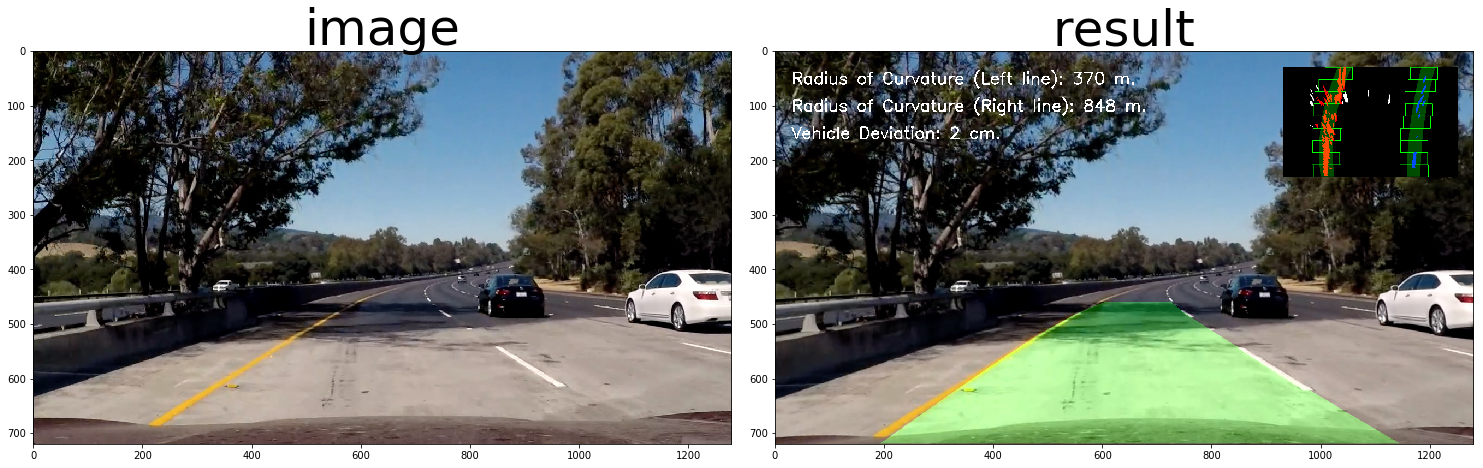

In [229]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
image = mpimg.imread('test_images/test5.jpg')
result = main(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(result)
ax2.set_title('result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.imshow(result)
#plt.imsave(image + "_found.png", result)
#plt.show()

In [237]:
#left_line = Line()
#right_line = Line()
detected = False
#output_video = 'first_diffcult_section.mp4'
output_video = 'submission_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(22,28)
video_clip = clip1.fl_image(main)
%time video_clip.write_videofile(output_video, audio=False)

#white_output = 'first_draft.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(main) #NOTE: this function expects color images!!
#time white_clip.write_videofile(white_output, audio=False)

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
776.832357639 m 716.097069665 m
[MoviePy] >>>> Building video submission_video.mp4
[MoviePy] Writing video submission_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:C:\Users\domin\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
776.832357639 m 716.097069665 m



  0%|          | 1/1261 [00:01<22:46,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
748.773847313 m 638.700851728 m



  0%|          | 2/1261 [00:02<22:41,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
715.67474838 m 887.745581764 m



  0%|          | 3/1261 [00:03<22:53,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
721.48785405 m 803.540728957 m



  0%|          | 4/1261 [00:04<23:18,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
689.538435969 m 834.16694073 m



  0%|          | 5/1261 [00:05<23:22,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
671.500342957 m 877.990012754 m



  0%|          | 6/1261 [00:06<23:17,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
716.707983165 m 929.978966236 m



  1%|          | 7/1261 [00:07<23:40,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
713.193199896 m 1265.19659093 m



  1%|          | 8/1261 [00:08<23:41,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
765.057027505 m 1302.98932857 m



  1%|          | 9/1261 [00:10<23:39,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
799.675449913 m 1115.3736718 m



  1%|          | 10/1261 [00:11<23:32,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
843.964725571 m 1238.44642033 m



  1%|          | 11/1261 [00:12<23:07,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
828.871341658 m 1409.90783047 m



  1%|          | 12/1261 [00:13<23:13,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
926.176285093 m 1026.27718206 m



  1%|          | 13/1261 [00:14<23:03,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1001.15563627 m 994.252715637 m



  1%|          | 14/1261 [00:15<22:43,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
961.170396125 m 1105.91599409 m



  1%|          | 15/1261 [00:16<22:21,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
955.595161279 m 1042.78377777 m



  1%|▏         | 16/1261 [00:17<22:15,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1015.01559882 m 1103.27294948 m



  1%|▏         | 17/1261 [00:18<22:17,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
992.76678702 m 1118.63226723 m



  1%|▏         | 18/1261 [00:19<22:05,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1114.77233578 m 1200.74637304 m



  2%|▏         | 19/1261 [00:20<22:03,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1120.6350967 m 1196.67987732 m



  2%|▏         | 20/1261 [00:21<22:00,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1152.65713485 m 1270.30671745 m



  2%|▏         | 21/1261 [00:23<22:02,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1321.2057893 m 1066.82383562 m



  2%|▏         | 22/1261 [00:24<22:11,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1217.19933827 m 1008.33834567 m



  2%|▏         | 23/1261 [00:25<22:04,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1235.53792038 m 1071.6217743 m



  2%|▏         | 24/1261 [00:26<21:56,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1102.78562583 m 946.772361497 m



  2%|▏         | 25/1261 [00:27<22:03,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1188.54845671 m 827.742965204 m



  2%|▏         | 26/1261 [00:28<21:52,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1145.49466519 m 902.101013517 m



  2%|▏         | 27/1261 [00:29<22:05,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1034.63075399 m 848.059100329 m



  2%|▏         | 28/1261 [00:30<22:01,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1001.27246237 m 754.432223654 m



  2%|▏         | 29/1261 [00:31<21:55,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
853.769834003 m 804.899239425 m



  2%|▏         | 30/1261 [00:32<21:55,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
793.355908682 m 826.4592167 m



  2%|▏         | 31/1261 [00:33<22:11,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
727.657790366 m 785.115628001 m



  3%|▎         | 32/1261 [00:34<22:32,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
720.150479926 m 918.407524892 m



  3%|▎         | 33/1261 [00:36<22:51,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
644.493690591 m 990.898896027 m



  3%|▎         | 34/1261 [00:37<23:19,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
623.35043316 m 1086.67034181 m



  3%|▎         | 35/1261 [00:38<23:21,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
597.290093548 m 989.47081361 m



  3%|▎         | 36/1261 [00:39<25:54,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
584.531099648 m 907.82406621 m



  3%|▎         | 37/1261 [00:41<27:19,  1.34s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
565.716368828 m 763.209877902 m



  3%|▎         | 38/1261 [00:42<26:19,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
533.597789626 m 832.718171679 m



  3%|▎         | 39/1261 [00:43<26:16,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
548.242839125 m 908.404890913 m



  3%|▎         | 40/1261 [00:46<32:37,  1.60s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
551.640279056 m 720.807780002 m



  3%|▎         | 41/1261 [00:47<32:40,  1.61s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
547.256097173 m 729.441513483 m



  3%|▎         | 42/1261 [00:48<29:22,  1.45s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
557.633885353 m 739.999280162 m



  3%|▎         | 43/1261 [00:50<27:35,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
576.006478336 m 757.474169038 m



  3%|▎         | 44/1261 [00:51<26:21,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
609.036587683 m 771.344884075 m



  4%|▎         | 45/1261 [00:52<25:06,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
640.340116796 m 1030.686557 m



  4%|▎         | 46/1261 [00:53<24:18,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
664.173602458 m 815.4016249 m



  4%|▎         | 47/1261 [00:54<23:36,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
680.198527024 m 841.417395067 m



  4%|▍         | 48/1261 [00:55<23:21,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
766.267841807 m 919.886882133 m



  4%|▍         | 49/1261 [00:56<23:23,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
818.840617004 m 838.019287015 m



  4%|▍         | 50/1261 [00:57<23:05,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
884.268777685 m 736.548119069 m



  4%|▍         | 51/1261 [00:59<22:53,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
928.278228687 m 705.719885711 m



  4%|▍         | 52/1261 [01:00<23:07,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
962.297383673 m 706.681363835 m



  4%|▍         | 53/1261 [01:01<23:01,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
954.86973543 m 724.778536522 m



  4%|▍         | 54/1261 [01:02<22:59,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1196.37243303 m 727.879429993 m



  4%|▍         | 55/1261 [01:03<22:55,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1273.25562602 m 766.921470431 m



  4%|▍         | 56/1261 [01:04<23:06,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1266.12058136 m 768.152587583 m



  5%|▍         | 57/1261 [01:05<22:57,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1247.94517294 m 821.66891811 m



  5%|▍         | 58/1261 [01:07<22:47,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1028.09960631 m 1135.21824812 m



  5%|▍         | 59/1261 [01:08<22:36,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1025.67161938 m 1118.4569804 m



  5%|▍         | 60/1261 [01:09<22:32,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
970.707599296 m 1086.52230412 m



  5%|▍         | 61/1261 [01:10<22:26,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
917.585443381 m 946.23446059 m



  5%|▍         | 62/1261 [01:11<22:31,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
910.793364807 m 782.332085314 m



  5%|▍         | 63/1261 [01:12<22:43,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
849.555697182 m 747.427073206 m



  5%|▌         | 64/1261 [01:13<22:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
777.942337879 m 907.564711431 m



  5%|▌         | 65/1261 [01:15<22:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
763.806517427 m 1012.12337848 m



  5%|▌         | 66/1261 [01:16<22:39,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
845.02816607 m 1060.12960306 m



  5%|▌         | 67/1261 [01:17<22:52,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
825.682815236 m 1109.07537597 m



  5%|▌         | 68/1261 [01:18<24:05,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
841.310525285 m 1088.2144222 m



  5%|▌         | 69/1261 [01:19<23:57,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
839.50457426 m 1195.80739481 m



  6%|▌         | 70/1261 [01:21<24:18,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
866.30633973 m 1961.9042688 m



  6%|▌         | 71/1261 [01:22<24:53,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
962.619363042 m 1612.96787877 m



  6%|▌         | 72/1261 [01:23<24:27,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1015.21960102 m 1800.44372107 m



  6%|▌         | 73/1261 [01:24<23:40,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1099.64235192 m 1486.44028846 m



  6%|▌         | 74/1261 [01:25<23:03,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1272.71948908 m 1419.65090198 m



  6%|▌         | 75/1261 [01:26<22:43,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1368.50436458 m 913.38708639 m



  6%|▌         | 76/1261 [01:28<22:44,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1391.6377134 m 869.391036153 m



  6%|▌         | 77/1261 [01:29<22:33,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1930.52292869 m 840.980677089 m



  6%|▌         | 78/1261 [01:30<22:26,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2077.14489858 m 1008.9959976 m



  6%|▋         | 79/1261 [01:31<22:29,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2981.43726897 m 748.699397081 m



  6%|▋         | 80/1261 [01:32<22:25,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2409.56737582 m 798.468820248 m



  6%|▋         | 81/1261 [01:33<22:29,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2313.59427636 m 814.752604218 m



  7%|▋         | 82/1261 [01:34<22:08,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1894.62212311 m 895.39421102 m



  7%|▋         | 83/1261 [01:36<21:56,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1985.81144861 m 1299.14158055 m



  7%|▋         | 84/1261 [01:37<22:07,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1711.33033244 m 1246.20434665 m



  7%|▋         | 85/1261 [01:38<22:11,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1525.5019711 m 1195.77509274 m



  7%|▋         | 86/1261 [01:39<22:14,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1200.89701371 m 1167.68631041 m



  7%|▋         | 87/1261 [01:40<22:36,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1013.22597123 m 795.633320332 m



  7%|▋         | 88/1261 [01:42<24:17,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
875.18718867 m 919.576324943 m



  7%|▋         | 89/1261 [01:43<25:11,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
799.257117758 m 821.278363275 m



  7%|▋         | 90/1261 [01:44<26:19,  1.35s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
857.007462476 m 889.968593356 m



  7%|▋         | 91/1261 [01:46<25:02,  1.28s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
887.947943591 m 952.186133872 m



  7%|▋         | 92/1261 [01:47<24:34,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
820.156485265 m 977.901573115 m



  7%|▋         | 93/1261 [01:48<24:41,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
824.44097641 m 996.599876513 m



  7%|▋         | 94/1261 [01:49<25:03,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
817.206016979 m 1046.7159665 m



  8%|▊         | 95/1261 [01:51<26:07,  1.34s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
799.802640394 m 1071.35733489 m



  8%|▊         | 96/1261 [01:52<26:50,  1.38s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
860.762653165 m 912.919506067 m



  8%|▊         | 97/1261 [01:54<25:25,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
823.483861581 m 1005.54011876 m



  8%|▊         | 98/1261 [01:55<26:25,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
870.18180424 m 1032.43573387 m



  8%|▊         | 99/1261 [01:57<28:22,  1.47s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
900.678442186 m 998.511557436 m



  8%|▊         | 100/1261 [01:58<27:18,  1.41s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
906.311237935 m 587.982584159 m



  8%|▊         | 101/1261 [01:59<26:46,  1.38s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
895.537717102 m 683.028760344 m



  8%|▊         | 102/1261 [02:00<25:14,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
852.60456553 m 703.333832722 m



  8%|▊         | 103/1261 [02:02<24:16,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
848.222101847 m 752.848230158 m



  8%|▊         | 104/1261 [02:03<23:32,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
945.998062717 m 780.443901337 m



  8%|▊         | 105/1261 [02:04<22:55,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
939.052920903 m 877.541659211 m



  8%|▊         | 106/1261 [02:05<22:30,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
902.70239914 m 903.115175565 m



  8%|▊         | 107/1261 [02:07<25:01,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
811.956549935 m 905.330598303 m



  9%|▊         | 108/1261 [02:08<25:08,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
788.289314075 m 1058.2754169 m



  9%|▊         | 109/1261 [02:09<25:54,  1.35s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
781.167787966 m 1062.3741642 m



  9%|▊         | 110/1261 [02:10<24:45,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
751.589440436 m 1157.77717629 m



  9%|▉         | 111/1261 [02:12<24:18,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
793.183400651 m 1301.45202988 m



  9%|▉         | 112/1261 [02:13<23:38,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
742.317515885 m 1356.459222 m



  9%|▉         | 113/1261 [02:14<23:11,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
723.083791922 m 1041.30574727 m



  9%|▉         | 114/1261 [02:15<22:34,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
682.820835571 m 1043.91075497 m



  9%|▉         | 115/1261 [02:16<22:11,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
677.90590517 m 637.215940143 m



  9%|▉         | 116/1261 [02:17<22:00,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
680.740571923 m 670.475475957 m



  9%|▉         | 117/1261 [02:19<23:04,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
655.129531048 m 645.331085065 m



  9%|▉         | 118/1261 [02:20<22:55,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
657.137983458 m 664.8369358 m



  9%|▉         | 119/1261 [02:21<22:44,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
637.117012904 m 619.525600776 m



 10%|▉         | 120/1261 [02:22<23:05,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
634.269009045 m 645.823578653 m



 10%|▉         | 121/1261 [02:23<22:29,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
648.3327913 m 633.08072041 m



 10%|▉         | 122/1261 [02:25<22:04,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
603.294322603 m 654.011001933 m



 10%|▉         | 123/1261 [02:26<21:45,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
618.551255319 m 653.3893078 m



 10%|▉         | 124/1261 [02:27<22:00,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
635.923890706 m 614.440216674 m



 10%|▉         | 125/1261 [02:28<22:29,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
648.481247083 m 556.239266348 m



 10%|▉         | 126/1261 [02:29<22:07,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
656.83351418 m 551.135681261 m



 10%|█         | 127/1261 [02:30<21:47,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
684.518739381 m 578.508873272 m



 10%|█         | 128/1261 [02:32<21:42,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
714.511238245 m 677.055353504 m



 10%|█         | 129/1261 [02:33<21:42,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
754.512760431 m 668.40975635 m



 10%|█         | 130/1261 [02:34<21:48,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
778.251403333 m 693.00644479 m



 10%|█         | 131/1261 [02:35<21:33,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
751.406003782 m 728.000310678 m



 10%|█         | 132/1261 [02:36<21:39,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
763.541628399 m 771.160726873 m



 11%|█         | 133/1261 [02:37<21:57,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
791.761136944 m 835.883775497 m



 11%|█         | 134/1261 [02:38<21:52,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
788.284135614 m 905.475958004 m



 11%|█         | 135/1261 [02:40<21:52,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
912.280579253 m 922.927466246 m



 11%|█         | 136/1261 [02:41<21:53,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
967.025149708 m 836.381315305 m



 11%|█         | 137/1261 [02:42<21:56,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1018.52812163 m 934.792953863 m



 11%|█         | 138/1261 [02:43<22:17,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
980.583405979 m 826.962364025 m



 11%|█         | 139/1261 [02:45<22:48,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1018.83339263 m 897.569752473 m



 11%|█         | 140/1261 [02:46<23:11,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1012.3841607 m 1020.19453117 m



 11%|█         | 141/1261 [02:47<23:08,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1021.82797983 m 990.754150803 m



 11%|█▏        | 142/1261 [02:48<22:54,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
914.702411309 m 1062.75056781 m



 11%|█▏        | 143/1261 [02:49<22:21,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
926.798754781 m 1065.47561811 m



 11%|█▏        | 144/1261 [02:50<21:46,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
950.795500428 m 1095.81341098 m



 11%|█▏        | 145/1261 [02:52<21:33,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1003.92031994 m 1021.29623694 m



 12%|█▏        | 146/1261 [02:53<21:18,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1109.45174541 m 1942.70270783 m



 12%|█▏        | 147/1261 [02:54<21:09,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
984.392150637 m 1460.79786448 m



 12%|█▏        | 148/1261 [02:55<21:05,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
982.388079326 m 1702.8853413 m



 12%|█▏        | 149/1261 [02:56<21:03,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1066.65967189 m 1470.25217094 m



 12%|█▏        | 150/1261 [02:57<21:06,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1047.84042312 m 952.143382493 m



 12%|█▏        | 151/1261 [02:58<21:01,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1182.54990465 m 1075.26477698 m



 12%|█▏        | 152/1261 [03:00<20:53,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1111.64136206 m 831.112778059 m



 12%|█▏        | 153/1261 [03:01<20:47,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1178.81707226 m 794.662464148 m



 12%|█▏        | 154/1261 [03:02<20:39,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1053.3753416 m 847.289442184 m



 12%|█▏        | 155/1261 [03:03<20:38,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1035.81126574 m 830.823636032 m



 12%|█▏        | 156/1261 [03:04<20:27,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1051.86184314 m 851.20738191 m



 12%|█▏        | 157/1261 [03:05<20:35,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
897.478637205 m 795.388454445 m



 13%|█▎        | 158/1261 [03:06<20:54,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
881.007786966 m 1045.54514151 m



 13%|█▎        | 159/1261 [03:07<20:53,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
770.259138557 m 1063.90952229 m



 13%|█▎        | 160/1261 [03:09<20:55,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
818.378635361 m 1182.5480506 m



 13%|█▎        | 161/1261 [03:10<21:24,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
844.108878716 m 1127.59146881 m



 13%|█▎        | 162/1261 [03:11<21:13,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
821.516599109 m 1080.81222148 m



 13%|█▎        | 163/1261 [03:12<21:20,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
865.595232717 m 1407.63168832 m



 13%|█▎        | 164/1261 [03:13<21:20,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
856.365528289 m 1236.72419559 m



 13%|█▎        | 165/1261 [03:14<21:19,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
897.290073439 m 1111.423236 m



 13%|█▎        | 166/1261 [03:16<21:01,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
818.478967617 m 928.581291907 m



 13%|█▎        | 167/1261 [03:17<20:59,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
960.766668411 m 1071.16893328 m



 13%|█▎        | 168/1261 [03:18<20:54,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1065.30211623 m 1001.59391638 m



 13%|█▎        | 169/1261 [03:19<20:52,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1103.15460165 m 1017.74666223 m



 13%|█▎        | 170/1261 [03:20<20:53,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1204.98281479 m 943.518910357 m



 14%|█▎        | 171/1261 [03:21<21:08,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1224.25868842 m 802.109588405 m



 14%|█▎        | 172/1261 [03:23<21:14,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1146.73065162 m 710.942918993 m



 14%|█▎        | 173/1261 [03:24<20:51,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1047.7725581 m 762.897599146 m



 14%|█▍        | 174/1261 [03:25<20:39,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
957.728438486 m 687.195061029 m



 14%|█▍        | 175/1261 [03:26<21:06,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
892.240667148 m 528.4090359 m



 14%|█▍        | 176/1261 [03:27<21:22,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
990.014368561 m 572.400160479 m



 14%|█▍        | 177/1261 [03:28<20:51,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
991.527103696 m 610.925998159 m



 14%|█▍        | 178/1261 [03:29<20:42,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
943.958052565 m 590.816744746 m



 14%|█▍        | 179/1261 [03:31<20:35,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
868.225703589 m 556.95557301 m



 14%|█▍        | 180/1261 [03:32<20:55,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
759.337597938 m 464.055540255 m



 14%|█▍        | 181/1261 [03:33<21:19,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
739.609779418 m 496.96334736 m



 14%|█▍        | 182/1261 [03:34<21:51,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
688.264843199 m 479.420856266 m



 15%|█▍        | 183/1261 [03:35<21:32,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
665.609648061 m 524.069468528 m



 15%|█▍        | 184/1261 [03:37<21:42,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
632.589689362 m 531.268792271 m



 15%|█▍        | 185/1261 [03:38<21:32,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
549.140954996 m 522.609790435 m



 15%|█▍        | 186/1261 [03:39<21:02,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
536.756457506 m 547.840411002 m



 15%|█▍        | 187/1261 [03:40<20:31,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
523.759514298 m 470.947022602 m



 15%|█▍        | 188/1261 [03:41<20:10,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
524.883085831 m 454.494238502 m



 15%|█▍        | 189/1261 [03:42<20:06,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
542.909682674 m 518.956987594 m



 15%|█▌        | 190/1261 [03:43<20:29,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
523.700748439 m 587.018477861 m



 15%|█▌        | 191/1261 [03:45<20:57,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
569.651984707 m 635.493529271 m



 15%|█▌        | 192/1261 [03:46<21:25,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
588.474794893 m 637.894824042 m



 15%|█▌        | 193/1261 [03:47<21:29,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
602.295398385 m 660.627381503 m



 15%|█▌        | 194/1261 [03:48<21:11,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
605.709007868 m 694.200174973 m



 15%|█▌        | 195/1261 [03:50<21:18,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
714.948934206 m 872.595271511 m



 16%|█▌        | 196/1261 [03:51<21:01,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
798.044058683 m 921.131879597 m



 16%|█▌        | 197/1261 [03:52<21:32,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
817.432316966 m 1027.78704439 m



 16%|█▌        | 198/1261 [03:53<21:27,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
868.933516402 m 1128.28452432 m



 16%|█▌        | 199/1261 [03:54<21:19,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
891.608182142 m 1042.02548369 m



 16%|█▌        | 200/1261 [03:56<21:37,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
985.036332642 m 892.09686751 m



 16%|█▌        | 201/1261 [03:57<21:15,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
948.345256353 m 874.390798659 m



 16%|█▌        | 202/1261 [03:58<20:46,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
984.236652072 m 923.070534549 m



 16%|█▌        | 203/1261 [03:59<21:00,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
957.081604577 m 1004.78508373 m



 16%|█▌        | 204/1261 [04:00<21:22,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
911.550191972 m 763.691464357 m



 16%|█▋        | 205/1261 [04:02<21:32,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
862.471934126 m 743.81449 m



 16%|█▋        | 206/1261 [04:03<21:51,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
723.642521688 m 705.614461468 m



 16%|█▋        | 207/1261 [04:04<21:52,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
697.460306247 m 862.777410072 m



 16%|█▋        | 208/1261 [04:05<21:39,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
736.135956367 m 830.407052957 m



 17%|█▋        | 209/1261 [04:07<21:11,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
760.819089605 m 821.717305003 m



 17%|█▋        | 210/1261 [04:08<20:39,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
757.662581946 m 808.294848788 m



 17%|█▋        | 211/1261 [04:09<20:51,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
788.301513669 m 765.506697436 m



 17%|█▋        | 212/1261 [04:10<20:26,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
763.650752101 m 641.192537212 m



 17%|█▋        | 213/1261 [04:11<20:21,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
734.645905003 m 724.987136157 m



 17%|█▋        | 214/1261 [04:12<20:16,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
701.817609127 m 655.297494832 m



 17%|█▋        | 215/1261 [04:13<20:15,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
738.827839556 m 685.584566975 m



 17%|█▋        | 216/1261 [04:15<20:14,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
698.136379175 m 827.133995798 m



 17%|█▋        | 217/1261 [04:16<20:14,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
753.776403353 m 888.745275686 m



 17%|█▋        | 218/1261 [04:17<20:13,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
718.359305909 m 870.972510138 m



 17%|█▋        | 219/1261 [04:18<19:59,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
797.483961992 m 987.932745857 m



 17%|█▋        | 220/1261 [04:19<19:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
825.10386391 m 1502.78063107 m



 18%|█▊        | 221/1261 [04:20<20:01,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
848.808176354 m 1384.28550672 m



 18%|█▊        | 222/1261 [04:22<20:14,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
892.480118765 m 1514.1772311 m



 18%|█▊        | 223/1261 [04:23<20:12,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
874.046421196 m 1413.14079442 m



 18%|█▊        | 224/1261 [04:24<19:59,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
975.06039154 m 2063.46245362 m



 18%|█▊        | 225/1261 [04:25<19:45,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
947.24442823 m 1934.81745203 m



 18%|█▊        | 226/1261 [04:26<19:29,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
971.734391986 m 2073.70718107 m



 18%|█▊        | 227/1261 [04:27<19:18,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1013.1784214 m 982.017178629 m



 18%|█▊        | 228/1261 [04:28<19:04,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1081.3694561 m 905.157112314 m



 18%|█▊        | 229/1261 [04:29<19:15,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1042.90400159 m 986.659428474 m



 18%|█▊        | 230/1261 [04:31<19:42,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1024.52124818 m 899.332093543 m



 18%|█▊        | 231/1261 [04:32<19:31,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1098.89552619 m 940.246425444 m



 18%|█▊        | 232/1261 [04:33<19:34,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1117.29776976 m 860.400328551 m



 18%|█▊        | 233/1261 [04:34<19:34,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1110.62202384 m 963.59298449 m



 19%|█▊        | 234/1261 [04:35<19:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1156.76145777 m 957.219324836 m



 19%|█▊        | 235/1261 [04:36<19:58,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1008.22351719 m 948.114166831 m



 19%|█▊        | 236/1261 [04:38<19:55,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1021.37036216 m 613.979807072 m



 19%|█▉        | 237/1261 [04:39<20:01,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
947.398706171 m 758.554814175 m



 19%|█▉        | 238/1261 [04:40<19:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
893.522069664 m 700.629135674 m



 19%|█▉        | 239/1261 [04:41<20:25,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
950.03432826 m 609.553025564 m



 19%|█▉        | 240/1261 [04:42<20:09,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
879.285798368 m 620.172913114 m



 19%|█▉        | 241/1261 [04:44<20:27,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
906.536252479 m 663.58803761 m



 19%|█▉        | 242/1261 [04:45<21:38,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
837.357088175 m 629.307970391 m



 19%|█▉        | 243/1261 [04:47<22:38,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
863.913717928 m 641.634313426 m



 19%|█▉        | 244/1261 [04:48<22:03,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
843.930043661 m 785.650591651 m



 19%|█▉        | 245/1261 [04:49<21:01,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
766.902984414 m 830.559818529 m



 20%|█▉        | 246/1261 [04:50<20:37,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
775.104958454 m 806.006006081 m



 20%|█▉        | 247/1261 [04:51<20:20,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
762.219591258 m 769.368325864 m



 20%|█▉        | 248/1261 [04:52<20:18,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
764.062227006 m 638.744391493 m



 20%|█▉        | 249/1261 [04:54<20:07,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
736.462918831 m 684.662652223 m



 20%|█▉        | 250/1261 [04:55<20:40,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
761.791079056 m 661.723244674 m



 20%|█▉        | 251/1261 [04:56<21:25,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
800.608704876 m 735.165558483 m



 20%|█▉        | 252/1261 [04:57<21:06,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
805.333897953 m 744.261209026 m



 20%|██        | 253/1261 [04:59<20:25,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
852.599334667 m 763.298965718 m



 20%|██        | 254/1261 [05:00<20:33,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
854.161597384 m 767.153371665 m



 20%|██        | 255/1261 [05:01<20:06,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
788.407882509 m 799.725146807 m



 20%|██        | 256/1261 [05:02<19:37,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
804.645286255 m 1028.416578 m



 20%|██        | 257/1261 [05:03<19:33,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
813.317323663 m 1045.99872267 m



 20%|██        | 258/1261 [05:04<19:13,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
807.587721863 m 1010.48505055 m



 21%|██        | 259/1261 [05:06<19:26,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
835.481764613 m 1041.80631491 m



 21%|██        | 260/1261 [05:07<19:25,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
953.95593343 m 1057.34627832 m



 21%|██        | 261/1261 [05:08<19:54,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
977.047133732 m 756.341707678 m



 21%|██        | 262/1261 [05:09<19:40,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1108.78645246 m 599.74620993 m



 21%|██        | 263/1261 [05:10<19:28,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1141.29552731 m 690.550571648 m



 21%|██        | 264/1261 [05:11<19:12,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1098.51338499 m 730.892704447 m



 21%|██        | 265/1261 [05:13<19:17,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1075.44972491 m 766.086133254 m



 21%|██        | 266/1261 [05:14<19:08,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1005.92008809 m 799.764258324 m



 21%|██        | 267/1261 [05:15<19:17,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
973.927839007 m 798.619982117 m



 21%|██▏       | 268/1261 [05:16<19:11,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
955.583035424 m 844.835287267 m



 21%|██▏       | 269/1261 [05:17<19:16,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
945.72015281 m 1043.24416006 m



 21%|██▏       | 270/1261 [05:18<19:02,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
950.912824158 m 998.278025823 m



 21%|██▏       | 271/1261 [05:20<19:06,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
894.118719583 m 906.15589315 m



 22%|██▏       | 272/1261 [05:21<19:40,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
940.344597312 m 903.111683788 m



 22%|██▏       | 273/1261 [05:22<19:36,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
917.67507097 m 842.770397866 m



 22%|██▏       | 274/1261 [05:23<19:45,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
941.908785028 m 849.67344459 m



 22%|██▏       | 275/1261 [05:24<19:22,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1077.01163168 m 972.065944989 m



 22%|██▏       | 276/1261 [05:25<18:55,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1125.36684893 m 943.392375391 m



 22%|██▏       | 277/1261 [05:27<18:37,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1148.54801885 m 949.606636237 m



 22%|██▏       | 278/1261 [05:28<18:45,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1133.69226221 m 941.026658131 m



 22%|██▏       | 279/1261 [05:29<18:37,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1093.64200672 m 972.030803883 m



 22%|██▏       | 280/1261 [05:30<19:00,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1251.62032412 m 1145.88938317 m



 22%|██▏       | 281/1261 [05:31<19:14,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1245.40713701 m 1156.16798204 m



 22%|██▏       | 282/1261 [05:32<18:49,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1343.93533566 m 1099.57711097 m



 22%|██▏       | 283/1261 [05:33<18:30,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1478.79073619 m 1238.59879592 m



 23%|██▎       | 284/1261 [05:35<18:20,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1359.1275667 m 1241.26581904 m



 23%|██▎       | 285/1261 [05:36<18:15,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1330.94656913 m 1351.63830518 m



 23%|██▎       | 286/1261 [05:37<18:12,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1466.98050814 m 1286.7566638 m



 23%|██▎       | 287/1261 [05:38<18:49,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1586.67884992 m 1254.8668045 m



 23%|██▎       | 288/1261 [05:39<18:37,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1598.75886954 m 1209.43461769 m



 23%|██▎       | 289/1261 [05:40<18:44,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1624.96190456 m 1173.07612265 m



 23%|██▎       | 290/1261 [05:41<18:45,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1421.55190462 m 1201.689836 m



 23%|██▎       | 291/1261 [05:43<19:00,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1479.0101796 m 1225.99714001 m



 23%|██▎       | 292/1261 [05:44<19:06,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1489.86889355 m 1476.94665446 m



 23%|██▎       | 293/1261 [05:45<18:57,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1549.25869711 m 1401.0773903 m



 23%|██▎       | 294/1261 [05:46<18:48,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1498.55200055 m 1401.24250254 m



 23%|██▎       | 295/1261 [05:47<18:52,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1796.41091786 m 1471.51398128 m



 23%|██▎       | 296/1261 [05:49<18:55,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1940.31113405 m 1392.59595297 m



 24%|██▎       | 297/1261 [05:50<18:31,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1910.17192122 m 967.967633742 m



 24%|██▎       | 298/1261 [05:51<18:36,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1971.19592914 m 1078.4575648 m



 24%|██▎       | 299/1261 [05:52<19:09,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2259.06300009 m 1117.87778412 m



 24%|██▍       | 300/1261 [05:53<19:33,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1837.07976422 m 1251.73746754 m



 24%|██▍       | 301/1261 [05:55<18:59,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2001.11963585 m 1297.6946131 m



 24%|██▍       | 302/1261 [05:56<18:49,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2318.63070119 m 1446.65720635 m



 24%|██▍       | 303/1261 [05:57<19:02,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2304.87526975 m 1412.78684077 m



 24%|██▍       | 304/1261 [05:58<19:03,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2769.82698279 m 2816.71275036 m



 24%|██▍       | 305/1261 [05:59<19:02,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3179.87182009 m 2888.99794068 m



 24%|██▍       | 306/1261 [06:01<19:24,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2882.33300778 m 2946.29575397 m



 24%|██▍       | 307/1261 [06:02<19:39,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2203.02743365 m 3156.75835952 m



 24%|██▍       | 308/1261 [06:03<19:22,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2448.60822109 m 4013.61920964 m



 25%|██▍       | 309/1261 [06:04<19:23,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2137.70667246 m 2588.94050595 m



 25%|██▍       | 310/1261 [06:05<19:13,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4284.8743062 m 22951.0272085 m



 25%|██▍       | 311/1261 [06:07<18:59,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5247.98532001 m 8679.34915718 m



 25%|██▍       | 312/1261 [06:08<18:52,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4285.59242652 m 14815.9792317 m



 25%|██▍       | 313/1261 [06:09<18:38,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
45934.3425102 m 7475.87334355 m



 25%|██▍       | 314/1261 [06:10<18:15,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
51022.9064612 m 7886.44320458 m



 25%|██▍       | 315/1261 [06:11<17:58,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
12009.1180595 m 7894.64920498 m



 25%|██▌       | 316/1261 [06:12<17:50,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
25980.8803715 m 7501.71758207 m



 25%|██▌       | 317/1261 [06:13<17:44,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
440373.757951 m 19291.2295694 m



 25%|██▌       | 318/1261 [06:15<18:01,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
320268.378405 m 14283.9080771 m



 25%|██▌       | 319/1261 [06:16<18:01,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8972.57643604 m 27734.4678791 m



 25%|██▌       | 320/1261 [06:17<18:17,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7178.91031314 m 12615.7878023 m



 25%|██▌       | 321/1261 [06:18<18:14,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7251.84656711 m 1520.44030912 m



 26%|██▌       | 322/1261 [06:19<18:31,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5640.72324055 m 1624.00710321 m



 26%|██▌       | 323/1261 [06:21<19:33,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2853.74373934 m 1996.17100287 m



 26%|██▌       | 324/1261 [06:22<21:14,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4413.16021999 m 2071.01226191 m



 26%|██▌       | 325/1261 [06:24<21:15,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7016.32729327 m 2222.30159738 m



 26%|██▌       | 326/1261 [06:25<21:20,  1.37s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6737.58449021 m 1928.17592899 m



 26%|██▌       | 327/1261 [06:26<20:27,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5085.64635644 m 2091.35060848 m



 26%|██▌       | 328/1261 [06:28<20:38,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10551.5671948 m 3180.28267217 m



 26%|██▌       | 329/1261 [06:29<20:08,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
57418.5828766 m 3436.65821133 m



 26%|██▌       | 330/1261 [06:30<19:43,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8686.38846549 m 3645.45512826 m



 26%|██▌       | 331/1261 [06:31<19:15,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6314.28991388 m 3158.21116295 m



 26%|██▋       | 332/1261 [06:32<18:49,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7070.96542409 m 3319.8468376 m



 26%|██▋       | 333/1261 [06:34<18:56,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8688.00996403 m 4285.06345256 m



 26%|██▋       | 334/1261 [06:35<18:44,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14533.4371483 m 4366.1382768 m



 27%|██▋       | 335/1261 [06:36<18:54,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
24865.1192354 m 3938.4761774 m



 27%|██▋       | 336/1261 [06:37<18:38,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23151.2213613 m 5164.7620871 m



 27%|██▋       | 337/1261 [06:38<18:25,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10170.1537373 m 5908.29503001 m



 27%|██▋       | 338/1261 [06:40<18:13,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10863.7222215 m 7032.10156145 m



 27%|██▋       | 339/1261 [06:41<18:14,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4658.65505098 m 8919.6260652 m



 27%|██▋       | 340/1261 [06:42<18:05,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9555.67003833 m 421653.795559 m



 27%|██▋       | 341/1261 [06:43<17:43,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11953.8306698 m 5412.90772159 m



 27%|██▋       | 342/1261 [06:44<17:56,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6130.19723126 m 5235.85552498 m



 27%|██▋       | 343/1261 [06:46<18:43,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3355.27233017 m 6603.55408067 m



 27%|██▋       | 344/1261 [06:47<19:11,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5505.62215789 m 4499.0975222 m



 27%|██▋       | 345/1261 [06:48<18:40,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4104.30135479 m 10790.9174164 m



 27%|██▋       | 346/1261 [06:49<18:39,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4817.03364814 m 3337.82590333 m



 28%|██▊       | 347/1261 [06:50<18:17,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4042.78044572 m 3603.71701991 m



 28%|██▊       | 348/1261 [06:52<17:50,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10200.8203792 m 7956.14774306 m



 28%|██▊       | 349/1261 [06:53<17:56,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
18327.4446459 m 9234.70274395 m



 28%|██▊       | 350/1261 [06:54<17:55,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
15124.5440801 m 8936.73380789 m



 28%|██▊       | 351/1261 [06:55<17:56,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7112.2135275 m 12358.1455375 m



 28%|██▊       | 352/1261 [06:56<18:00,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4818.76610759 m 8906.03328626 m



 28%|██▊       | 353/1261 [06:57<17:52,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3032.14102208 m 17795.2324832 m



 28%|██▊       | 354/1261 [06:59<18:09,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2806.02595178 m 4596.42229294 m



 28%|██▊       | 355/1261 [07:00<17:47,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2361.3565036 m 194295.659018 m



 28%|██▊       | 356/1261 [07:01<17:40,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1810.79983682 m 161774.596115 m



 28%|██▊       | 357/1261 [07:02<18:03,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2628.91952344 m 4521.51200138 m



 28%|██▊       | 358/1261 [07:03<17:34,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3839.80057816 m 2342.51229426 m



 28%|██▊       | 359/1261 [07:05<17:35,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
36690.485971 m 2832.24171442 m



 29%|██▊       | 360/1261 [07:06<17:46,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23655.287312 m 2685.81224657 m



 29%|██▊       | 361/1261 [07:07<17:59,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9985.40517395 m 3115.43568982 m



 29%|██▊       | 362/1261 [07:08<18:05,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4534.63303118 m 3605.5207037 m



 29%|██▉       | 363/1261 [07:09<17:57,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3026.29189104 m 3412.40448126 m



 29%|██▉       | 364/1261 [07:11<17:37,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2438.45076941 m 6803.2196271 m



 29%|██▉       | 365/1261 [07:12<17:37,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1908.47792162 m 20128.9213048 m



 29%|██▉       | 366/1261 [07:13<18:05,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2061.98000221 m 166918.812155 m



 29%|██▉       | 367/1261 [07:14<18:19,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1438.04460303 m 19361.2011844 m



 29%|██▉       | 368/1261 [07:16<18:24,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1073.29695402 m 5821.10169259 m



 29%|██▉       | 369/1261 [07:17<18:32,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1289.17781554 m 5023.88429858 m



 29%|██▉       | 370/1261 [07:18<18:15,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1319.53858971 m 5986.59442239 m



 29%|██▉       | 371/1261 [07:19<18:03,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1448.81192662 m 8950.30227924 m



 30%|██▉       | 372/1261 [07:20<18:13,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1914.79731758 m 7571.34735547 m



 30%|██▉       | 373/1261 [07:22<17:49,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1630.26971012 m 9276.80230539 m



 30%|██▉       | 374/1261 [07:23<17:34,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3327.60749419 m 9291.51326446 m



 30%|██▉       | 375/1261 [07:24<17:08,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
32575.8124641 m 8165.88941611 m



 30%|██▉       | 376/1261 [07:25<16:51,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
20971.9782389 m 2873.16769579 m



 30%|██▉       | 377/1261 [07:26<16:38,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5720.88947199 m 4739.94638747 m



 30%|██▉       | 378/1261 [07:27<16:27,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3423.83235968 m 5844.06235038 m



 30%|███       | 379/1261 [07:28<16:15,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2665.5535444 m 4134.75438946 m



 30%|███       | 380/1261 [07:29<16:10,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4712.30912275 m 6327.60089493 m



 30%|███       | 381/1261 [07:30<16:07,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6129.92305041 m 4219.57858143 m



 30%|███       | 382/1261 [07:32<16:15,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5523.35460153 m 15978.4958576 m



 30%|███       | 383/1261 [07:33<16:13,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6624.06236545 m 25447.9355176 m



 30%|███       | 384/1261 [07:34<16:14,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8905.60597245 m 48999.6735341 m



 31%|███       | 385/1261 [07:35<16:11,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9835.20627572 m 18329.9257227 m



 31%|███       | 386/1261 [07:36<16:13,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11096.8378008 m 43657.5872891 m



 31%|███       | 387/1261 [07:37<16:14,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
12152.0716305 m 174528.225487 m



 31%|███       | 388/1261 [07:38<16:05,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
19467.3179053 m 245111.317464 m



 31%|███       | 389/1261 [07:39<16:04,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
112056.20281 m 6098.11825357 m



 31%|███       | 390/1261 [07:40<15:59,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5998.75571905 m 6418.45054202 m



 31%|███       | 391/1261 [07:41<15:54,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8379.1067633 m 7132.23824053 m



 31%|███       | 392/1261 [07:43<16:05,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11387.4419039 m 8789.81874824 m



 31%|███       | 393/1261 [07:44<16:01,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4685.12720814 m 21000.2802526 m



 31%|███       | 394/1261 [07:45<16:06,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4976.92737913 m 162408.033156 m



 31%|███▏      | 395/1261 [07:46<16:00,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8934.02622397 m 10549.5713163 m



 31%|███▏      | 396/1261 [07:47<15:54,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8179.33889417 m 5527.99166241 m



 31%|███▏      | 397/1261 [07:48<15:55,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5057.65559165 m 15794.9638892 m



 32%|███▏      | 398/1261 [07:49<15:51,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4893.93814781 m 6613.56407318 m



 32%|███▏      | 399/1261 [07:50<15:48,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4929.4527344 m 10818.1918805 m



 32%|███▏      | 400/1261 [07:51<15:51,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4255.82561279 m 7262.5834009 m



 32%|███▏      | 401/1261 [07:53<15:57,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3972.13539747 m 3221.13943277 m



 32%|███▏      | 402/1261 [07:54<15:53,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7328.96623689 m 2907.85816945 m



 32%|███▏      | 403/1261 [07:55<16:00,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5748.5381662 m 4871.77313587 m



 32%|███▏      | 404/1261 [07:56<16:20,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
18420.7160608 m 4447.94327986 m



 32%|███▏      | 405/1261 [07:57<16:12,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
49570.9068298 m 14559.1889056 m



 32%|███▏      | 406/1261 [07:58<16:01,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
58564.0000908 m 6725.15599227 m



 32%|███▏      | 407/1261 [07:59<15:56,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6304.42492927 m 17249.2163846 m



 32%|███▏      | 408/1261 [08:00<15:53,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4291.5080258 m 4579.09513702 m



 32%|███▏      | 409/1261 [08:02<15:51,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9082.43176089 m 11957.4544935 m



 33%|███▎      | 410/1261 [08:03<15:47,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6285.07127511 m 1091214.54938 m



 33%|███▎      | 411/1261 [08:04<15:42,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
41383.6403224 m 52623.9470726 m



 33%|███▎      | 412/1261 [08:05<15:38,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
26304.0224862 m 53749.4180089 m



 33%|███▎      | 413/1261 [08:06<15:36,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
15766.9611364 m 5028.07334612 m



 33%|███▎      | 414/1261 [08:07<15:39,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11501.0127662 m 5039.69398076 m



 33%|███▎      | 415/1261 [08:08<15:36,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4814.68048324 m 4409.35054257 m



 33%|███▎      | 416/1261 [08:09<15:32,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3426.64562976 m 6748.06704986 m



 33%|███▎      | 417/1261 [08:10<15:29,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3072.04287372 m 7425.00127071 m



 33%|███▎      | 418/1261 [08:11<15:27,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2534.06247361 m 6669.6395257 m



 33%|███▎      | 419/1261 [08:13<15:25,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2501.56519846 m 8065.51033085 m



 33%|███▎      | 420/1261 [08:14<15:28,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4454.68298776 m 2161.14245317 m



 33%|███▎      | 421/1261 [08:15<15:22,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6281.23427056 m 49662.5871 m



 33%|███▎      | 422/1261 [08:16<15:21,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8503.70470403 m 100103.294537 m



 34%|███▎      | 423/1261 [08:17<15:20,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6612.61209189 m 29220.0553659 m



 34%|███▎      | 424/1261 [08:18<15:22,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3775.49573066 m 8903.18030201 m



 34%|███▎      | 425/1261 [08:19<15:19,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3611.55186251 m 4349.03634842 m



 34%|███▍      | 426/1261 [08:20<15:21,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6484.80104689 m 6942.73045213 m



 34%|███▍      | 427/1261 [08:21<15:23,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
22284.9170599 m 3685.38671898 m



 34%|███▍      | 428/1261 [08:23<15:29,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14568.7404566 m 7418.87721594 m



 34%|███▍      | 429/1261 [08:24<15:18,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
12404.8756743 m 21891.7622839 m



 34%|███▍      | 430/1261 [08:25<15:18,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4297.20768407 m 125557.001281 m



 34%|███▍      | 431/1261 [08:26<15:14,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8400.13358727 m 11580.696523 m



 34%|███▍      | 432/1261 [08:27<15:15,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
75287.4019064 m 11425.5315796 m



 34%|███▍      | 433/1261 [08:28<15:13,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
45582.6246657 m 8292.69747508 m



 34%|███▍      | 434/1261 [08:29<15:09,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
77778.5086194 m 10626.0283783 m



 34%|███▍      | 435/1261 [08:30<15:13,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
51665.0219841 m 8647.8776444 m



 35%|███▍      | 436/1261 [08:31<15:10,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
13279.4465204 m 13206.1738315 m



 35%|███▍      | 437/1261 [08:32<15:05,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
18793.1869613 m 69106.4982268 m



 35%|███▍      | 438/1261 [08:34<15:09,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4608.15670586 m 32230.5918946 m



 35%|███▍      | 439/1261 [08:35<15:14,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3840.67545171 m 18088.1682792 m



 35%|███▍      | 440/1261 [08:36<15:20,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3865.71594948 m 36627.222646 m



 35%|███▍      | 441/1261 [08:37<15:11,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6520.56738253 m 4157.22925502 m



 35%|███▌      | 442/1261 [08:38<15:11,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5423.98770403 m 6234.01688913 m



 35%|███▌      | 443/1261 [08:39<15:07,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4545.84477604 m 26892.811767 m



 35%|███▌      | 444/1261 [08:40<15:06,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6087.30288498 m 11319.2327714 m



 35%|███▌      | 445/1261 [08:41<15:13,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2720.56091583 m 4133.82751508 m



 35%|███▌      | 446/1261 [08:43<15:38,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2619.26282782 m 5050.25432165 m



 35%|███▌      | 447/1261 [08:44<15:20,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
12127.6768418 m 4509.96031677 m



 36%|███▌      | 448/1261 [08:45<15:51,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3406.04878177 m 868094.462412 m



 36%|███▌      | 449/1261 [08:46<16:27,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3675.16706746 m 29901.3154726 m



 36%|███▌      | 450/1261 [08:48<16:40,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3238.00719695 m 3344.49803595 m



 36%|███▌      | 451/1261 [08:49<16:11,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3247.59030968 m 12464.2111785 m



 36%|███▌      | 452/1261 [08:50<15:51,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4396.83785375 m 7027.53250615 m



 36%|███▌      | 453/1261 [08:51<15:26,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10282.3930474 m 3296.00641446 m



 36%|███▌      | 454/1261 [08:52<15:23,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5027.72128509 m 4588.4942873 m



 36%|███▌      | 455/1261 [08:53<15:23,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7086.48240542 m 3273.0265194 m



 36%|███▌      | 456/1261 [08:54<15:08,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9194.77464289 m 7383.72151049 m



 36%|███▌      | 457/1261 [08:55<15:01,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5035.25721951 m 5328.88645694 m



 36%|███▋      | 458/1261 [08:56<14:53,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
18469.3832621 m 9715.87509881 m



 36%|███▋      | 459/1261 [08:58<14:51,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7632.98837787 m 11108.6687699 m



 36%|███▋      | 460/1261 [08:59<14:43,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5257.20371583 m 5014.34318729 m



 37%|███▋      | 461/1261 [09:00<14:41,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3561.74262743 m 9469.61160235 m



 37%|███▋      | 462/1261 [09:01<14:46,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3407.00504841 m 19645.3623096 m



 37%|███▋      | 463/1261 [09:02<15:21,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3461.19169591 m 7270.7653397 m



 37%|███▋      | 464/1261 [09:03<15:17,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3022.54407233 m 24184.854074 m



 37%|███▋      | 465/1261 [09:04<14:56,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3268.03046976 m 8340.45511098 m



 37%|███▋      | 466/1261 [09:05<14:51,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3122.42873808 m 182606.564187 m



 37%|███▋      | 467/1261 [09:07<14:48,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3204.50886346 m 8754.09357982 m



 37%|███▋      | 468/1261 [09:08<15:09,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4811.14829606 m 4361.05228183 m



 37%|███▋      | 469/1261 [09:09<15:09,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4582.64563771 m 3977.25906602 m



 37%|███▋      | 470/1261 [09:10<14:56,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3275.20044255 m 3550.1363617 m



 37%|███▋      | 471/1261 [09:11<15:18,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3328.25573003 m 3099.99643064 m



 37%|███▋      | 472/1261 [09:13<15:43,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3698.81279046 m 2273.53674399 m



 38%|███▊      | 473/1261 [09:14<15:32,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4953.07215158 m 3868.50023599 m



 38%|███▊      | 474/1261 [09:15<15:15,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5822.2141307 m 5185.44481734 m



 38%|███▊      | 475/1261 [09:16<15:06,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10388.2410579 m 4605.13709029 m



 38%|███▊      | 476/1261 [09:17<15:41,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7963.91066601 m 3901.4184526 m



 38%|███▊      | 477/1261 [09:18<15:20,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
59682.6736595 m 12700.9230586 m



 38%|███▊      | 478/1261 [09:19<15:09,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
62694.7289448 m 9199.94902994 m



 38%|███▊      | 479/1261 [09:21<15:06,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
18259.0279524 m 15542.1462658 m



 38%|███▊      | 480/1261 [09:22<15:11,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14041.4240239 m 8589.80542268 m



 38%|███▊      | 481/1261 [09:23<15:18,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6109.2391701 m 9715.32089075 m



 38%|███▊      | 482/1261 [09:24<15:19,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3652.60695527 m 7967.84655088 m



 38%|███▊      | 483/1261 [09:25<15:26,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6204.72353047 m 17266.3519376 m



 38%|███▊      | 484/1261 [09:27<15:22,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11918.3854802 m 5538.41060108 m



 38%|███▊      | 485/1261 [09:28<15:32,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14020.7618096 m 149781.26625 m



 39%|███▊      | 486/1261 [09:29<15:30,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
84883.2069907 m 61368.4006739 m



 39%|███▊      | 487/1261 [09:30<15:06,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
61052.8925132 m 8750.08595849 m



 39%|███▊      | 488/1261 [09:31<15:23,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
35163.6648619 m 28806.8018836 m



 39%|███▉      | 489/1261 [09:33<15:11,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
100907.144609 m 50792.7819656 m



 39%|███▉      | 490/1261 [09:34<15:17,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23892.025898 m 15526.6019242 m



 39%|███▉      | 491/1261 [09:35<15:00,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
13823.5639807 m 91529.5513519 m



 39%|███▉      | 492/1261 [09:36<15:08,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6685.26019189 m 4026.12678265 m



 39%|███▉      | 493/1261 [09:37<15:07,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
17253.0968813 m 4809.94336325 m



 39%|███▉      | 494/1261 [09:39<15:18,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8740.04237077 m 5798.18913839 m



 39%|███▉      | 495/1261 [09:40<15:21,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8617.86929708 m 4650.80244904 m



 39%|███▉      | 496/1261 [09:41<15:05,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
48625.7113207 m 6751.90370421 m



 39%|███▉      | 497/1261 [09:42<14:47,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
13139.3628252 m 5727.47424284 m



 39%|███▉      | 498/1261 [09:43<14:56,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10001.7067667 m 17061.6862181 m



 40%|███▉      | 499/1261 [09:44<14:38,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6168.41028828 m 14352.8872467 m



 40%|███▉      | 500/1261 [09:45<14:26,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7025.55205152 m 8918.33481425 m



 40%|███▉      | 501/1261 [09:46<14:13,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
344910.482913 m 95580.7345981 m



 40%|███▉      | 502/1261 [09:48<14:19,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
39049.6729072 m 26787.2342788 m



 40%|███▉      | 503/1261 [09:49<14:35,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9241.24898525 m 30612.0227437 m



 40%|███▉      | 504/1261 [09:50<14:39,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7090.16008754 m 8183.77541529 m



 40%|████      | 505/1261 [09:51<14:45,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
10602.5914036 m 24596.149191 m



 40%|████      | 506/1261 [09:53<15:13,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
16650.6026756 m 11825.6301686 m



 40%|████      | 507/1261 [09:54<15:02,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
36214.2182064 m 26655.7201083 m



 40%|████      | 508/1261 [09:55<15:07,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11994.5620669 m 3419.85700741 m



 40%|████      | 509/1261 [09:56<15:06,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8592.62794496 m 8268.59671213 m



 40%|████      | 510/1261 [09:57<14:45,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7017.43806706 m 5478.71058544 m



 41%|████      | 511/1261 [09:58<14:37,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4014.5409108 m 5147.29500171 m



 41%|████      | 512/1261 [10:00<14:33,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2546.75184901 m 6658.9587569 m



 41%|████      | 513/1261 [10:01<14:29,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2395.2472038 m 11409.2061264 m



 41%|████      | 514/1261 [10:02<14:34,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1831.03480287 m 6640.35389744 m



 41%|████      | 515/1261 [10:03<14:43,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1318.96921808 m 11395.3747257 m



 41%|████      | 516/1261 [10:04<14:54,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
916.228165802 m 3630.40227782 m



 41%|████      | 517/1261 [10:06<16:26,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5220.32271712 m 3178.43634841 m



 41%|████      | 518/1261 [10:07<16:45,  1.35s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6825.83347499 m 3121.30983327 m



 41%|████      | 519/1261 [10:09<18:00,  1.46s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1754.29007671 m 4776.81592584 m



 41%|████      | 520/1261 [10:10<17:53,  1.45s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1512.07338971 m 28231.0402227 m



 41%|████▏     | 521/1261 [10:12<16:44,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1975.53045156 m 24165.1389484 m



 41%|████▏     | 522/1261 [10:13<15:53,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23253.8057795 m 9381.9458544 m



 41%|████▏     | 523/1261 [10:14<16:52,  1.37s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3042.47668135 m 6539.63475893 m



 42%|████▏     | 524/1261 [10:15<16:06,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
934.254723854 m 18037.8363173 m



 42%|████▏     | 525/1261 [10:17<15:14,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1379.38307313 m 8938.9550019 m



 42%|████▏     | 526/1261 [10:18<14:40,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
699.025127219 m 9498.05412117 m



 42%|████▏     | 527/1261 [10:19<14:23,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1067.57063933 m 10528.1649674 m



 42%|████▏     | 528/1261 [10:20<14:02,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1099.86539238 m 4657.06554573 m



 42%|████▏     | 529/1261 [10:21<13:42,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6118.51313815 m 3667.23229553 m



 42%|████▏     | 530/1261 [10:22<13:40,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2158.12752472 m 3526.9467726 m



 42%|████▏     | 531/1261 [10:23<13:43,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2971.9839542 m 4592.21757217 m



 42%|████▏     | 532/1261 [10:24<13:37,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2473.50630544 m 349107.364363 m



 42%|████▏     | 533/1261 [10:25<13:38,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1319.17694996 m 5502.00296531 m



 42%|████▏     | 534/1261 [10:27<13:38,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
953.184090458 m 4004.23155511 m



 42%|████▏     | 535/1261 [10:28<13:44,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
812.506516465 m 2524.72911341 m



 43%|████▎     | 536/1261 [10:29<14:03,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
699.27642022 m 3270.86701148 m



 43%|████▎     | 537/1261 [10:30<14:09,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1258.19587926 m 3601.23770003 m



 43%|████▎     | 538/1261 [10:31<13:46,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4342.30994308 m 5534.49523963 m



 43%|████▎     | 539/1261 [10:32<13:29,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3924.88368416 m 3115.99019492 m



 43%|████▎     | 540/1261 [10:33<13:31,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3517.01220966 m 2553.8447018 m



 43%|████▎     | 541/1261 [10:35<13:34,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5833.22041769 m 2452.9100405 m



 43%|████▎     | 542/1261 [10:36<13:48,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
9255.75439258 m 2747.68936135 m



 43%|████▎     | 543/1261 [10:37<13:57,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7632.94401267 m 2596.27601066 m



 43%|████▎     | 544/1261 [10:38<13:56,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
13451.2095655 m 1212.27833257 m



 43%|████▎     | 545/1261 [10:39<13:41,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6245.09077778 m 1048.69205911 m



 43%|████▎     | 546/1261 [10:40<13:20,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3136.63080269 m 885.51241643 m



 43%|████▎     | 547/1261 [10:42<13:37,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4468.22818049 m 1067.75654146 m



 43%|████▎     | 548/1261 [10:43<13:33,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4439.27600407 m 1177.7580634 m



 44%|████▎     | 549/1261 [10:44<13:34,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2286.82402583 m 1249.94998497 m



 44%|████▎     | 550/1261 [10:45<14:22,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1627.96535432 m 3534.73373008 m



 44%|████▎     | 551/1261 [10:46<14:24,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3629.95953414 m 6531.89850533 m



 44%|████▍     | 552/1261 [10:48<14:10,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1870.4698947 m 18783.1750377 m



 44%|████▍     | 553/1261 [10:49<13:57,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2143.42875779 m 74522.9112642 m



 44%|████▍     | 554/1261 [10:50<13:52,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
970.757403683 m 7841.78274297 m



 44%|████▍     | 555/1261 [10:51<13:39,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
802.411251788 m 4783.53096691 m



 44%|████▍     | 556/1261 [10:52<14:27,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
797.494829286 m 5595.84908097 m



 44%|████▍     | 557/1261 [10:54<14:32,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
810.682042213 m 3795.79421163 m



 44%|████▍     | 558/1261 [10:55<14:59,  1.28s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1032.85262435 m 4491.13614457 m



 44%|████▍     | 559/1261 [10:56<15:19,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2815.70358981 m 16219.3010591 m



 44%|████▍     | 560/1261 [10:58<15:27,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2563.77864385 m 13303.6494994 m



 44%|████▍     | 561/1261 [10:59<16:02,  1.37s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1758.35053357 m 2130.55366994 m



 45%|████▍     | 562/1261 [11:01<15:57,  1.37s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2471.41553696 m 5384.85052697 m



 45%|████▍     | 563/1261 [11:02<15:39,  1.35s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
950.985963133 m 13305.8300091 m



 45%|████▍     | 564/1261 [11:03<15:08,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1677.23688545 m 1469.44940405 m



 45%|████▍     | 565/1261 [11:04<14:21,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1455.50765468 m 1815.50258646 m



 45%|████▍     | 566/1261 [11:05<13:47,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
635.419136325 m 2264.42260208 m



 45%|████▍     | 567/1261 [11:06<13:18,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
848.775464678 m 1957.59468437 m



 45%|████▌     | 568/1261 [11:07<13:00,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
791.991460552 m 1863.50055271 m



 45%|████▌     | 569/1261 [11:08<12:45,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
930.085750558 m 1683.82008751 m



 45%|████▌     | 570/1261 [11:10<12:53,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2208.10329809 m 24626.6709279 m



 45%|████▌     | 571/1261 [11:11<12:40,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2151.29031515 m 4433.08690997 m



 45%|████▌     | 572/1261 [11:12<13:02,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2250.42858525 m 11211.4875467 m



 45%|████▌     | 573/1261 [11:13<12:58,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1805.29453409 m 1978.44123373 m



 46%|████▌     | 574/1261 [11:14<12:54,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3749.33509828 m 2030.83231098 m



 46%|████▌     | 575/1261 [11:15<12:36,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1363.66191622 m 1963.58757951 m



 46%|████▌     | 576/1261 [11:16<12:21,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1665.35270753 m 2417.72986276 m



 46%|████▌     | 577/1261 [11:17<12:28,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
977.571986246 m 2094.97465668 m



 46%|████▌     | 578/1261 [11:18<12:45,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2858.37404349 m 2320.51975963 m



 46%|████▌     | 579/1261 [11:20<12:36,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1134.92520493 m 2395.80462459 m



 46%|████▌     | 580/1261 [11:21<12:43,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3132.37916839 m 2176.79573654 m



 46%|████▌     | 581/1261 [11:22<13:20,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1105.69762446 m 1784.43213254 m



 46%|████▌     | 582/1261 [11:23<13:05,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2350.40039371 m 1761.46404222 m



 46%|████▌     | 583/1261 [11:24<12:41,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
885.460526263 m 4267.93187487 m



 46%|████▋     | 584/1261 [11:25<12:29,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
898.430686081 m 3499.57087955 m



 46%|████▋     | 585/1261 [11:26<12:15,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1266.06996867 m 2737.03072585 m



 46%|████▋     | 586/1261 [11:27<12:12,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
916.499468494 m 2319.64502552 m



 47%|████▋     | 587/1261 [11:28<12:08,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
988.755227927 m 2217.02938984 m



 47%|████▋     | 588/1261 [11:30<12:01,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
957.560674041 m 1534.46706462 m



 47%|████▋     | 589/1261 [11:31<12:00,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1005.87436057 m 1563.42693772 m



 47%|████▋     | 590/1261 [11:32<11:51,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
867.245263677 m 1910.27378226 m



 47%|████▋     | 591/1261 [11:33<12:14,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
721.45875212 m 1735.1183333 m



 47%|████▋     | 592/1261 [11:34<12:21,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
875.770005758 m 3145.35253984 m



 47%|████▋     | 593/1261 [11:35<12:24,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1127.80574689 m 3575.37122877 m



 47%|████▋     | 594/1261 [11:36<12:14,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1190.44662281 m 1790.7494043 m



 47%|████▋     | 595/1261 [11:37<12:12,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1035.32292573 m 2268.91127874 m



 47%|████▋     | 596/1261 [11:38<12:22,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
825.197587462 m 1796.11473534 m



 47%|████▋     | 597/1261 [11:39<12:11,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
717.122760129 m 1973.50436876 m



 47%|████▋     | 598/1261 [11:41<12:05,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
991.992203087 m 2819.37104634 m



 48%|████▊     | 599/1261 [11:42<11:53,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1284.50302631 m 2564.28667627 m



 48%|████▊     | 600/1261 [11:43<11:51,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3130.21795349 m 4290.8238881 m



 48%|████▊     | 601/1261 [11:44<12:02,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1942.18735423 m 3023.98906618 m



 48%|████▊     | 602/1261 [11:45<12:21,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2412.79237412 m 2312.44630616 m



 48%|████▊     | 603/1261 [11:46<12:14,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1195.95316502 m 33556.9828678 m



 48%|████▊     | 604/1261 [11:47<12:20,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1181.87123028 m 1622.9412101 m



 48%|████▊     | 605/1261 [11:48<12:05,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
728.259629207 m 993.268230701 m



 48%|████▊     | 606/1261 [11:49<11:55,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1214.61668192 m 972.68702829 m



 48%|████▊     | 607/1261 [11:50<11:56,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
927.281639469 m 940.229254334 m



 48%|████▊     | 608/1261 [11:51<11:45,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
594.229067675 m 1086.4119655 m



 48%|████▊     | 609/1261 [11:53<11:59,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1034.4432331 m 791.134743171 m



 48%|████▊     | 610/1261 [11:54<12:12,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
887.99079413 m 722.760058479 m



 48%|████▊     | 611/1261 [11:55<12:02,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
636.653644047 m 621.058877032 m



 49%|████▊     | 612/1261 [11:56<11:57,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1028.02602745 m 449.792109725 m



 49%|████▊     | 613/1261 [11:57<11:49,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
879.593807255 m 699.165289554 m



 49%|████▊     | 614/1261 [11:58<11:43,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
818.127757477 m 755.574037098 m



 49%|████▉     | 615/1261 [11:59<11:36,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
806.257847983 m 717.540144343 m



 49%|████▉     | 616/1261 [12:00<11:40,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2814.78944657 m 742.803150665 m



 49%|████▉     | 617/1261 [12:02<12:11,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
776.537526192 m 855.863467257 m



 49%|████▉     | 618/1261 [12:03<12:17,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
483.798526388 m 687.292865218 m



 49%|████▉     | 619/1261 [12:04<12:20,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
507.956584199 m 746.264797532 m



 49%|████▉     | 620/1261 [12:05<12:21,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1086.46215096 m 769.626941689 m



 49%|████▉     | 621/1261 [12:06<12:31,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
471.221251809 m 1215.99418238 m



 49%|████▉     | 622/1261 [12:07<12:33,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
560.917177906 m 1370.67237155 m



 49%|████▉     | 623/1261 [12:09<12:22,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
493.562207051 m 1644.66826595 m



 49%|████▉     | 624/1261 [12:10<12:09,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
534.776639051 m 1318.4874443 m



 50%|████▉     | 625/1261 [12:11<12:04,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
298.995302291 m 1377.86997434 m



 50%|████▉     | 626/1261 [12:12<11:52,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
296.518128361 m 1426.14511825 m



 50%|████▉     | 627/1261 [12:13<11:38,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
355.641772077 m 1548.16901828 m



 50%|████▉     | 628/1261 [12:14<11:35,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
353.157332568 m 1012.49967756 m



 50%|████▉     | 629/1261 [12:15<11:22,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
415.515018392 m 1068.14851354 m



 50%|████▉     | 630/1261 [12:16<11:37,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
621.220487704 m 1986.46830271 m



 50%|█████     | 631/1261 [12:17<11:32,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1039.10201227 m 1828.19140607 m



 50%|█████     | 632/1261 [12:18<11:45,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1089.98203429 m 1645.60544004 m



 50%|█████     | 633/1261 [12:20<11:59,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1221.75278934 m 1560.36568967 m



 50%|█████     | 634/1261 [12:21<12:01,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
701.485223109 m 1457.78641231 m



 50%|█████     | 635/1261 [12:22<11:57,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
757.808893447 m 895.372565632 m



 50%|█████     | 636/1261 [12:23<11:58,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
694.329848041 m 773.791403058 m



 51%|█████     | 637/1261 [12:24<12:03,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
649.052375737 m 791.403937131 m



 51%|█████     | 638/1261 [12:25<11:49,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1131.64162611 m 832.456810666 m



 51%|█████     | 639/1261 [12:27<11:50,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1971.67523572 m 937.631501038 m



 51%|█████     | 640/1261 [12:28<11:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1980.16059665 m 1183.67230196 m



 51%|█████     | 641/1261 [12:29<12:15,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5159.13826694 m 1279.90215016 m



 51%|█████     | 642/1261 [12:30<12:15,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2375.93467885 m 1052.4820726 m



 51%|█████     | 643/1261 [12:31<12:08,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1821.2362237 m 902.656917734 m



 51%|█████     | 644/1261 [12:33<12:16,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2319.05273588 m 941.517462343 m



 51%|█████     | 645/1261 [12:34<12:48,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4328.17726111 m 934.865702982 m



 51%|█████     | 646/1261 [12:35<12:35,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2270.05168766 m 1153.72941967 m



 51%|█████▏    | 647/1261 [12:36<12:09,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2423.08661361 m 1040.81360004 m



 51%|█████▏    | 648/1261 [12:37<11:46,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1446.43109772 m 951.099772409 m



 51%|█████▏    | 649/1261 [12:38<11:26,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1503.31200766 m 1025.70161551 m



 52%|█████▏    | 650/1261 [12:39<11:24,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1121.04878175 m 973.09462908 m



 52%|█████▏    | 651/1261 [12:41<11:08,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
913.48598432 m 939.472459644 m



 52%|█████▏    | 652/1261 [12:42<11:03,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1065.1450073 m 890.722539437 m



 52%|█████▏    | 653/1261 [12:43<10:58,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
975.236303916 m 871.207649909 m



 52%|█████▏    | 654/1261 [12:44<11:19,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
946.410056043 m 754.926610904 m



 52%|█████▏    | 655/1261 [12:45<12:21,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
736.882034959 m 793.00290699 m



 52%|█████▏    | 656/1261 [12:48<15:58,  1.58s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
671.995399745 m 837.524406564 m



 52%|█████▏    | 657/1261 [12:50<16:38,  1.65s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
765.187705098 m 915.717212568 m



 52%|█████▏    | 658/1261 [12:51<15:52,  1.58s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
606.813038538 m 1268.25089353 m



 52%|█████▏    | 659/1261 [12:52<14:38,  1.46s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
959.474233949 m 1281.138036 m



 52%|█████▏    | 660/1261 [12:53<13:52,  1.38s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
738.230143368 m 1437.58663325 m



 52%|█████▏    | 661/1261 [12:55<13:20,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
743.01202846 m 1445.50042692 m



 52%|█████▏    | 662/1261 [12:56<13:08,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
695.138563416 m 1393.27669933 m



 53%|█████▎    | 663/1261 [12:57<12:58,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
805.151142124 m 1394.23696709 m



 53%|█████▎    | 664/1261 [12:58<12:41,  1.28s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
724.915872854 m 1370.33251973 m



 53%|█████▎    | 665/1261 [12:59<12:17,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
836.396468875 m 1310.32630643 m



 53%|█████▎    | 666/1261 [13:01<12:02,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
969.386523014 m 953.926782546 m



 53%|█████▎    | 667/1261 [13:02<12:00,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1035.11122311 m 1116.11093921 m



 53%|█████▎    | 668/1261 [13:03<12:01,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1249.27994194 m 1165.02529361 m



 53%|█████▎    | 669/1261 [13:04<11:55,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1246.79458584 m 1151.88976627 m



 53%|█████▎    | 670/1261 [13:06<12:03,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1253.68135448 m 2546.52259621 m



 53%|█████▎    | 671/1261 [13:07<11:48,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1043.51625554 m 2634.07232336 m



 53%|█████▎    | 672/1261 [13:08<11:45,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1290.67403209 m 2006.173914 m



 53%|█████▎    | 673/1261 [13:09<11:40,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1227.27118364 m 1403.2885617 m



 53%|█████▎    | 674/1261 [13:10<11:47,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1434.73311609 m 1308.78563603 m



 54%|█████▎    | 675/1261 [13:11<11:40,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1245.87193891 m 1188.60465104 m



 54%|█████▎    | 676/1261 [13:13<11:39,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1309.00540476 m 1201.82265469 m



 54%|█████▎    | 677/1261 [13:14<11:36,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1474.17149945 m 1188.72682256 m



 54%|█████▍    | 678/1261 [13:15<11:46,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1427.45933177 m 826.992126492 m



 54%|█████▍    | 679/1261 [13:16<12:08,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1301.71667878 m 956.556093128 m



 54%|█████▍    | 680/1261 [13:18<11:47,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
931.528318755 m 945.792814876 m



 54%|█████▍    | 681/1261 [13:19<11:41,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1140.09650286 m 876.869598306 m



 54%|█████▍    | 682/1261 [13:20<11:45,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1105.65355371 m 934.586588195 m



 54%|█████▍    | 683/1261 [13:21<11:43,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1346.78660151 m 1014.56223317 m



 54%|█████▍    | 684/1261 [13:22<11:33,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1563.96243227 m 998.159003473 m



 54%|█████▍    | 685/1261 [13:24<11:22,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2317.99294097 m 1062.9363456 m



 54%|█████▍    | 686/1261 [13:25<11:06,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1158.91070415 m 1082.95147211 m



 54%|█████▍    | 687/1261 [13:26<11:00,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1089.74370587 m 1138.77143551 m



 55%|█████▍    | 688/1261 [13:27<10:54,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1658.67221218 m 1155.15340429 m



 55%|█████▍    | 689/1261 [13:28<11:09,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1468.86873665 m 1154.43938915 m



 55%|█████▍    | 690/1261 [13:29<11:04,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
945.419104416 m 1135.88993306 m



 55%|█████▍    | 691/1261 [13:30<11:01,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
883.399826595 m 1037.54444211 m



 55%|█████▍    | 692/1261 [13:32<11:07,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
808.919030833 m 1015.46361157 m



 55%|█████▍    | 693/1261 [13:33<11:09,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
764.636441242 m 1176.3450478 m



 55%|█████▌    | 694/1261 [13:34<11:00,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
737.924669359 m 1150.98204834 m



 55%|█████▌    | 695/1261 [13:35<11:11,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
706.943741506 m 1517.23455848 m



 55%|█████▌    | 696/1261 [13:36<11:06,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
800.976593435 m 1870.32135926 m



 55%|█████▌    | 697/1261 [13:38<11:02,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
773.767920044 m 1087.2958834 m



 55%|█████▌    | 698/1261 [13:39<10:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
731.470856719 m 1202.19276443 m



 55%|█████▌    | 699/1261 [13:40<10:55,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
779.347120971 m 1049.24763877 m



 56%|█████▌    | 700/1261 [13:41<10:47,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
572.282926244 m 1047.70191785 m



 56%|█████▌    | 701/1261 [13:42<10:39,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
548.19317795 m 1102.99465337 m



 56%|█████▌    | 702/1261 [13:43<10:42,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
627.400055184 m 1018.88920733 m



 56%|█████▌    | 703/1261 [13:44<10:58,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
681.624586073 m 786.35729681 m



 56%|█████▌    | 704/1261 [13:46<11:16,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
852.689330261 m 759.555573604 m



 56%|█████▌    | 705/1261 [13:47<10:54,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
927.301901599 m 795.919042309 m



 56%|█████▌    | 706/1261 [13:48<10:39,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1155.49556009 m 776.71276208 m



 56%|█████▌    | 707/1261 [13:49<10:27,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1150.13016386 m 873.174196448 m



 56%|█████▌    | 708/1261 [13:50<10:15,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1224.22807667 m 935.971784061 m



 56%|█████▌    | 709/1261 [13:51<10:11,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1142.22926202 m 826.023956816 m



 56%|█████▋    | 710/1261 [13:52<10:13,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1283.07169778 m 875.776708072 m



 56%|█████▋    | 711/1261 [13:53<10:08,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1444.39326377 m 896.54821384 m



 56%|█████▋    | 712/1261 [13:55<10:24,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
852.692287875 m 925.393151027 m



 57%|█████▋    | 713/1261 [13:56<10:45,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1075.20387393 m 869.874353847 m



 57%|█████▋    | 714/1261 [13:57<10:40,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1337.22454605 m 887.299563252 m



 57%|█████▋    | 715/1261 [13:58<10:43,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1159.32609675 m 806.707732493 m



 57%|█████▋    | 716/1261 [13:59<10:40,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1636.22062747 m 848.382653759 m



 57%|█████▋    | 717/1261 [14:01<10:31,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2069.91199327 m 868.80425163 m



 57%|█████▋    | 718/1261 [14:02<10:23,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2445.45631351 m 929.41043124 m



 57%|█████▋    | 719/1261 [14:03<11:20,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3768.6396487 m 895.61956444 m



 57%|█████▋    | 720/1261 [14:04<10:57,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1353.90740558 m 1091.79551219 m



 57%|█████▋    | 721/1261 [14:05<10:44,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1339.31386449 m 1027.97591878 m



 57%|█████▋    | 722/1261 [14:07<10:37,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1235.48904322 m 1178.07232383 m



 57%|█████▋    | 723/1261 [14:08<10:35,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1338.55078245 m 1220.34921928 m



 57%|█████▋    | 724/1261 [14:09<10:31,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
998.927353295 m 1048.59866668 m



 57%|█████▋    | 725/1261 [14:10<10:25,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
868.408192784 m 1197.58853045 m



 58%|█████▊    | 726/1261 [14:11<10:15,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1161.34880704 m 1172.4724798 m



 58%|█████▊    | 727/1261 [14:12<10:07,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1337.25105441 m 1135.56213142 m



 58%|█████▊    | 728/1261 [14:13<10:04,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
706.538838291 m 1042.51366529 m



 58%|█████▊    | 729/1261 [14:15<09:59,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1217.66430646 m 934.402393963 m



 58%|█████▊    | 730/1261 [14:16<09:52,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
817.906032122 m 889.747063009 m



 58%|█████▊    | 731/1261 [14:17<09:48,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1026.02062496 m 939.862525282 m



 58%|█████▊    | 732/1261 [14:18<09:49,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
683.303405605 m 1264.98350897 m



 58%|█████▊    | 733/1261 [14:19<09:46,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
930.118445075 m 1096.12759505 m



 58%|█████▊    | 734/1261 [14:20<09:46,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
850.770749168 m 1305.61283454 m



 58%|█████▊    | 735/1261 [14:21<09:49,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
884.291745951 m 1202.13504511 m



 58%|█████▊    | 736/1261 [14:22<09:44,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
794.601305294 m 1139.85987712 m



 58%|█████▊    | 737/1261 [14:23<09:45,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
585.956067057 m 1105.12394233 m



 59%|█████▊    | 738/1261 [14:25<09:37,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
686.917275 m 1118.83745487 m



 59%|█████▊    | 739/1261 [14:26<09:40,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
981.698778351 m 709.618913591 m



 59%|█████▊    | 740/1261 [14:27<09:34,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1075.56456407 m 696.835786557 m



 59%|█████▉    | 741/1261 [14:28<09:41,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1070.29013393 m 741.38777786 m



 59%|█████▉    | 742/1261 [14:29<09:46,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1142.64712422 m 674.471967547 m



 59%|█████▉    | 743/1261 [14:30<09:44,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
904.099101228 m 698.446654194 m



 59%|█████▉    | 744/1261 [14:31<09:40,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1096.03293324 m 754.368195579 m



 59%|█████▉    | 745/1261 [14:33<09:59,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
832.137261907 m 749.246150411 m



 59%|█████▉    | 746/1261 [14:34<10:26,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1083.5325799 m 830.586202763 m



 59%|█████▉    | 747/1261 [14:35<10:21,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1080.35203295 m 968.938227552 m



 59%|█████▉    | 748/1261 [14:36<10:30,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1093.05745585 m 820.980469054 m



 59%|█████▉    | 749/1261 [14:38<10:19,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1071.03505983 m 1000.6854424 m



 59%|█████▉    | 750/1261 [14:39<10:11,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1194.8572334 m 766.83300458 m



 60%|█████▉    | 751/1261 [14:40<10:03,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1249.45433732 m 249.072916884 m



 60%|█████▉    | 752/1261 [14:41<10:17,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1186.22831785 m 1146.59961072 m



 60%|█████▉    | 753/1261 [14:42<10:08,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1488.37541623 m 1025.37286358 m



 60%|█████▉    | 754/1261 [14:44<10:12,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
965.788554785 m 873.267542426 m



 60%|█████▉    | 755/1261 [14:45<10:30,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
849.863437244 m 1091.53703988 m



 60%|█████▉    | 756/1261 [14:46<10:50,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
912.770820238 m 2251.34074142 m



 60%|██████    | 757/1261 [14:48<10:56,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1152.0360463 m 1392.32801832 m



 60%|██████    | 758/1261 [14:49<10:29,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1046.17454732 m 1032.41410494 m



 60%|██████    | 759/1261 [14:50<10:10,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1245.03726478 m 1026.91225009 m



 60%|██████    | 760/1261 [14:51<10:01,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
886.455132758 m 823.230714635 m



 60%|██████    | 761/1261 [14:52<09:53,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
752.209658468 m 680.686254944 m



 60%|██████    | 762/1261 [14:53<09:43,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
743.043833665 m 649.246884554 m



 61%|██████    | 763/1261 [14:54<09:35,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
696.121881961 m 285.148203342 m



 61%|██████    | 764/1261 [14:56<09:34,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
728.206151632 m 253.284533034 m



 61%|██████    | 765/1261 [14:57<09:41,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
785.276905529 m 226.73685662 m



 61%|██████    | 766/1261 [14:58<09:56,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
764.821733593 m 1703.96840051 m



 61%|██████    | 767/1261 [14:59<09:49,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
700.804066557 m 2116.64360606 m



 61%|██████    | 768/1261 [15:00<09:52,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
591.342168602 m 10859.5967585 m



 61%|██████    | 769/1261 [15:02<09:55,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
726.091110039 m 3678.17991644 m



 61%|██████    | 770/1261 [15:03<09:42,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
705.831818592 m 4979.07719135 m



 61%|██████    | 771/1261 [15:04<09:33,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
744.239814818 m 3543.46249427 m



 61%|██████    | 772/1261 [15:05<09:27,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
811.547642546 m 3067.12144485 m



 61%|██████▏   | 773/1261 [15:06<09:25,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
840.68269208 m 2427.43752612 m



 61%|██████▏   | 774/1261 [15:07<09:30,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
858.731302908 m 2118.2647969 m



 61%|██████▏   | 775/1261 [15:09<09:27,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
808.927145391 m 728.663690914 m



 62%|██████▏   | 776/1261 [15:10<09:26,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
710.965463182 m 1796.05833599 m



 62%|██████▏   | 777/1261 [15:11<09:30,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
880.193738445 m 1396.1575281 m



 62%|██████▏   | 778/1261 [15:12<09:39,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
756.137503365 m 1259.0932592 m



 62%|██████▏   | 779/1261 [15:13<09:37,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
796.065915119 m 1519.50163104 m



 62%|██████▏   | 780/1261 [15:15<09:35,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1125.57929881 m 1948.91175348 m



 62%|██████▏   | 781/1261 [15:16<09:36,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1115.7754711 m 1389.679848 m



 62%|██████▏   | 782/1261 [15:17<09:39,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1033.52344191 m 1763.5804607 m



 62%|██████▏   | 783/1261 [15:18<09:43,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1100.33021325 m 1670.84810498 m



 62%|██████▏   | 784/1261 [15:20<09:44,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
977.258207065 m 2216.9818822 m



 62%|██████▏   | 785/1261 [15:21<09:41,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
859.287732219 m 1258.8817216 m



 62%|██████▏   | 786/1261 [15:22<09:51,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
879.811549105 m 1342.8674236 m



 62%|██████▏   | 787/1261 [15:23<09:39,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
907.834172634 m 1218.83796337 m



 62%|██████▏   | 788/1261 [15:24<09:35,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1000.56246093 m 1088.59811805 m



 63%|██████▎   | 789/1261 [15:26<09:42,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1223.54677802 m 866.065418685 m



 63%|██████▎   | 790/1261 [15:27<09:42,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1302.38855396 m 808.916459686 m



 63%|██████▎   | 791/1261 [15:28<09:29,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1448.73179108 m 1219.63312218 m



 63%|██████▎   | 792/1261 [15:29<09:17,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1707.74040584 m 926.180834288 m



 63%|██████▎   | 793/1261 [15:30<09:25,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1747.66277561 m 1161.45297179 m



 63%|██████▎   | 794/1261 [15:32<09:17,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1649.03279408 m 1730.61207805 m



 63%|██████▎   | 795/1261 [15:33<09:22,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1646.3867315 m 1535.11246247 m



 63%|██████▎   | 796/1261 [15:34<09:09,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1669.18348531 m 1412.98349649 m



 63%|██████▎   | 797/1261 [15:35<09:09,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1738.64470721 m 1396.54637222 m



 63%|██████▎   | 798/1261 [15:36<09:01,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1826.29554555 m 1417.33458627 m



 63%|██████▎   | 799/1261 [15:38<09:07,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1831.41346022 m 1829.09631785 m



 63%|██████▎   | 800/1261 [15:39<08:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2056.59497162 m 1594.92847213 m



 64%|██████▎   | 801/1261 [15:40<09:05,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2298.83689558 m 1716.43999671 m



 64%|██████▎   | 802/1261 [15:41<09:17,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2310.30238786 m 1577.67800433 m



 64%|██████▎   | 803/1261 [15:42<09:14,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1608.51373175 m 3541.34056656 m



 64%|██████▍   | 804/1261 [15:44<09:03,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1390.47254109 m 4792.0158795 m



 64%|██████▍   | 805/1261 [15:45<09:01,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1269.09630663 m 3211.76275392 m



 64%|██████▍   | 806/1261 [15:46<09:03,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1453.18549527 m 2880.57022691 m



 64%|██████▍   | 807/1261 [15:47<09:05,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1035.71603252 m 2757.23928713 m



 64%|██████▍   | 808/1261 [15:48<08:58,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1010.44231134 m 2666.86915095 m



 64%|██████▍   | 809/1261 [15:50<09:04,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
976.16208688 m 2704.46919591 m



 64%|██████▍   | 810/1261 [15:51<08:55,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
874.216265788 m 2667.52630142 m



 64%|██████▍   | 811/1261 [15:52<08:57,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
938.33593127 m 1096.85380921 m



 64%|██████▍   | 812/1261 [15:53<08:47,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
896.352741038 m 1196.09309327 m



 64%|██████▍   | 813/1261 [15:54<08:53,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
975.689257595 m 1419.36516355 m



 65%|██████▍   | 814/1261 [15:55<08:57,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1027.2307594 m 1525.25774685 m



 65%|██████▍   | 815/1261 [15:57<08:49,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
767.088038395 m 1385.7634535 m



 65%|██████▍   | 816/1261 [15:58<08:52,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
820.07348403 m 1388.55985871 m



 65%|██████▍   | 817/1261 [15:59<09:04,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
906.061410923 m 812.010682253 m



 65%|██████▍   | 818/1261 [16:00<09:04,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
832.631901153 m 836.487854575 m



 65%|██████▍   | 819/1261 [16:02<08:57,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
837.896984905 m 832.547186137 m



 65%|██████▌   | 820/1261 [16:03<08:53,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
861.521601408 m 838.456971732 m



 65%|██████▌   | 821/1261 [16:04<08:47,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1104.87562343 m 847.794381047 m



 65%|██████▌   | 822/1261 [16:05<08:43,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1044.03073345 m 862.679733459 m



 65%|██████▌   | 823/1261 [16:06<08:30,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1050.88628397 m 741.86751957 m



 65%|██████▌   | 824/1261 [16:07<08:24,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1331.33127014 m 791.760525263 m



 65%|██████▌   | 825/1261 [16:09<08:33,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1169.88725084 m 755.864671097 m



 66%|██████▌   | 826/1261 [16:10<08:35,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1190.12002226 m 822.444673636 m



 66%|██████▌   | 827/1261 [16:11<08:36,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1152.10106778 m 1156.13970911 m



 66%|██████▌   | 828/1261 [16:12<08:41,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1163.97971498 m 886.961121485 m



 66%|██████▌   | 829/1261 [16:13<08:38,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1582.46333609 m 949.150227919 m



 66%|██████▌   | 830/1261 [16:15<08:36,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1548.82970371 m 945.914806964 m



 66%|██████▌   | 831/1261 [16:16<08:33,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1490.05767067 m 920.220821508 m



 66%|██████▌   | 832/1261 [16:17<08:40,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1358.17584337 m 926.242086301 m



 66%|██████▌   | 833/1261 [16:18<08:37,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1083.95295148 m 939.07814857 m



 66%|██████▌   | 834/1261 [16:19<08:38,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
801.164396568 m 776.794872611 m



 66%|██████▌   | 835/1261 [16:21<08:50,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
957.336419139 m 789.677866582 m



 66%|██████▋   | 836/1261 [16:22<09:25,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1025.13384289 m 845.168014803 m



 66%|██████▋   | 837/1261 [16:24<09:13,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
773.753719188 m 849.655605048 m



 66%|██████▋   | 838/1261 [16:25<08:53,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
827.262978144 m 770.038126517 m



 67%|██████▋   | 839/1261 [16:26<08:51,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
766.32135929 m 781.022156971 m



 67%|██████▋   | 840/1261 [16:27<08:40,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
848.615629063 m 851.82736584 m



 67%|██████▋   | 841/1261 [16:28<08:26,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
825.082153935 m 857.193778923 m



 67%|██████▋   | 842/1261 [16:29<08:24,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
829.188211167 m 863.139195909 m



 67%|██████▋   | 843/1261 [16:31<08:26,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1056.63345669 m 896.328908556 m



 67%|██████▋   | 844/1261 [16:32<08:31,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
987.392387486 m 1147.73756765 m



 67%|██████▋   | 845/1261 [16:33<08:21,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
925.260033677 m 1067.01390751 m



 67%|██████▋   | 846/1261 [16:34<08:28,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1213.24962373 m 1266.61776852 m



 67%|██████▋   | 847/1261 [16:36<08:31,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
972.610409226 m 1119.20378811 m



 67%|██████▋   | 848/1261 [16:37<08:27,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1197.84285349 m 1169.39776031 m



 67%|██████▋   | 849/1261 [16:38<08:23,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
969.01450166 m 1079.39640066 m



 67%|██████▋   | 850/1261 [16:39<08:11,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1366.86634595 m 1414.31678921 m



 67%|██████▋   | 851/1261 [16:40<08:10,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1558.43105836 m 1455.57277161 m



 68%|██████▊   | 852/1261 [16:42<08:04,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1481.26901479 m 1731.1479872 m



 68%|██████▊   | 853/1261 [16:43<08:01,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1813.81338195 m 1564.64137942 m



 68%|██████▊   | 854/1261 [16:44<08:05,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3072.37308025 m 1722.90617084 m



 68%|██████▊   | 855/1261 [16:45<08:41,  1.28s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2393.4281219 m 1653.90268687 m



 68%|██████▊   | 856/1261 [16:47<08:49,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2740.04085664 m 1821.85334917 m



 68%|██████▊   | 857/1261 [16:48<08:41,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1413.86928168 m 1536.68849447 m



 68%|██████▊   | 858/1261 [16:49<08:23,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1479.54958336 m 1192.56642225 m



 68%|██████▊   | 859/1261 [16:50<08:11,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1253.89591831 m 1094.13240432 m



 68%|██████▊   | 860/1261 [16:52<08:01,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1339.04451313 m 872.508704133 m



 68%|██████▊   | 861/1261 [16:53<07:59,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1428.51216881 m 882.011709076 m



 68%|██████▊   | 862/1261 [16:54<07:53,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1908.77847983 m 900.924312472 m



 68%|██████▊   | 863/1261 [16:55<07:56,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1973.17001537 m 893.875397965 m



 69%|██████▊   | 864/1261 [16:56<07:52,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1892.51035482 m 967.369045362 m



 69%|██████▊   | 865/1261 [16:57<07:42,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1839.49255963 m 918.467690395 m



 69%|██████▊   | 866/1261 [16:59<07:37,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2075.33429331 m 1074.66078029 m



 69%|██████▉   | 867/1261 [17:00<07:35,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1896.44197841 m 753.121334204 m



 69%|██████▉   | 868/1261 [17:01<07:39,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1688.62292191 m 691.864442106 m



 69%|██████▉   | 869/1261 [17:02<07:31,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2139.07710796 m 789.736782132 m



 69%|██████▉   | 870/1261 [17:03<07:40,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1515.02399254 m 1724.583118 m



 69%|██████▉   | 871/1261 [17:04<07:39,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1745.80001114 m 1632.62776838 m



 69%|██████▉   | 872/1261 [17:06<07:32,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1503.43794366 m 1739.81291462 m



 69%|██████▉   | 873/1261 [17:07<07:29,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1525.80349969 m 1711.37434668 m



 69%|██████▉   | 874/1261 [17:08<07:25,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1558.65490113 m 2526.8106011 m



 69%|██████▉   | 875/1261 [17:09<07:24,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1480.88212605 m 1246.89961843 m



 69%|██████▉   | 876/1261 [17:10<07:33,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1585.5849401 m 1249.33306269 m



 70%|██████▉   | 877/1261 [17:11<07:32,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1250.25614389 m 1305.38505313 m



 70%|██████▉   | 878/1261 [17:13<07:24,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1241.54483522 m 1505.19889417 m



 70%|██████▉   | 879/1261 [17:14<07:24,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
987.520420933 m 1273.25025711 m



 70%|██████▉   | 880/1261 [17:15<07:26,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
985.258153504 m 927.916510788 m



 70%|██████▉   | 881/1261 [17:16<07:23,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1279.08074225 m 541.708018698 m



 70%|██████▉   | 882/1261 [17:17<07:18,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1076.71646538 m 2542.83852621 m



 70%|███████   | 883/1261 [17:19<07:43,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1445.37256929 m 2930.36432032 m



 70%|███████   | 884/1261 [17:20<07:52,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1545.04488895 m 1779.284359 m



 70%|███████   | 885/1261 [17:21<08:15,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1286.01198078 m 1086.38366329 m



 70%|███████   | 886/1261 [17:22<07:56,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1318.05027493 m 1151.28809072 m



 70%|███████   | 887/1261 [17:24<07:43,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1282.15950415 m 1708.73496159 m



 70%|███████   | 888/1261 [17:25<07:33,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1372.10111386 m 1394.35013159 m



 70%|███████   | 889/1261 [17:26<07:33,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2276.10924859 m 1199.04769228 m



 71%|███████   | 890/1261 [17:27<07:39,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3933.34661088 m 1136.27693555 m



 71%|███████   | 891/1261 [17:29<07:32,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3752.13216796 m 1044.29667989 m



 71%|███████   | 892/1261 [17:30<07:24,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2651.92920685 m 1909.07124587 m



 71%|███████   | 893/1261 [17:31<07:27,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2724.91909582 m 1474.02293554 m



 71%|███████   | 894/1261 [17:32<07:19,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1796.62376748 m 1802.89045241 m



 71%|███████   | 895/1261 [17:33<07:12,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1524.43298368 m 1534.39127006 m



 71%|███████   | 896/1261 [17:34<07:03,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1652.04234141 m 1460.19996032 m



 71%|███████   | 897/1261 [17:36<07:04,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1403.25098366 m 2075.27797485 m



 71%|███████   | 898/1261 [17:37<06:58,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1575.11839308 m 2658.76707866 m



 71%|███████▏  | 899/1261 [17:38<06:55,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1860.73063541 m 2753.09323807 m



 71%|███████▏  | 900/1261 [17:39<06:54,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2493.73415338 m 2120.88902819 m



 71%|███████▏  | 901/1261 [17:40<06:50,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2021.91402129 m 2641.7897486 m



 72%|███████▏  | 902/1261 [17:41<06:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2389.5337019 m 2916.33617805 m



 72%|███████▏  | 903/1261 [17:42<06:54,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3387.27715727 m 2093.76620932 m



 72%|███████▏  | 904/1261 [17:44<06:53,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4381.71861523 m 1454.22345982 m



 72%|███████▏  | 905/1261 [17:45<07:08,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2872.63485772 m 1082.17734799 m



 72%|███████▏  | 906/1261 [17:46<07:18,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1921.56150135 m 1080.85833819 m



 72%|███████▏  | 907/1261 [17:47<07:02,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1283.71650502 m 955.500695098 m



 72%|███████▏  | 908/1261 [17:48<07:01,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1123.44026404 m 784.949956603 m



 72%|███████▏  | 909/1261 [17:50<06:49,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1213.06734936 m 910.132509194 m



 72%|███████▏  | 910/1261 [17:51<06:47,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1298.48164387 m 894.852607995 m



 72%|███████▏  | 911/1261 [17:52<06:40,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1314.63123267 m 929.670196337 m



 72%|███████▏  | 912/1261 [17:53<06:39,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1245.91912237 m 830.256126963 m



 72%|███████▏  | 913/1261 [17:54<06:45,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1493.18185429 m 813.343906289 m



 72%|███████▏  | 914/1261 [17:55<06:40,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1200.04641849 m 888.663782244 m



 73%|███████▎  | 915/1261 [17:56<06:37,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
754.51216679 m 1042.84812265 m



 73%|███████▎  | 916/1261 [17:58<06:35,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
850.104736044 m 1146.05087198 m



 73%|███████▎  | 917/1261 [17:59<06:31,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1039.84961998 m 1411.04883497 m



 73%|███████▎  | 918/1261 [18:00<06:33,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
910.116563648 m 1433.83323193 m



 73%|███████▎  | 919/1261 [18:01<06:40,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
777.912675777 m 1255.16335039 m



 73%|███████▎  | 920/1261 [18:02<06:35,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
874.090601757 m 1018.0036621 m



 73%|███████▎  | 921/1261 [18:03<06:28,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
839.029453786 m 1291.84703963 m



 73%|███████▎  | 922/1261 [18:04<06:32,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1043.79079834 m 1487.85335677 m



 73%|███████▎  | 923/1261 [18:06<06:53,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1004.59066572 m 1109.81493009 m



 73%|███████▎  | 924/1261 [18:07<06:46,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
756.85642716 m 1393.36768099 m



 73%|███████▎  | 925/1261 [18:08<06:31,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
789.47733479 m 1482.50082785 m



 73%|███████▎  | 926/1261 [18:09<06:26,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
875.269859861 m 1633.07201856 m



 74%|███████▎  | 927/1261 [18:10<06:18,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
940.560038024 m 1521.6418756 m



 74%|███████▎  | 928/1261 [18:11<06:18,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1374.54361635 m 1651.51810841 m



 74%|███████▎  | 929/1261 [18:13<06:19,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1426.80421455 m 1211.33797624 m



 74%|███████▍  | 930/1261 [18:14<06:19,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1557.73232106 m 957.115021918 m



 74%|███████▍  | 931/1261 [18:15<06:12,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1770.13879391 m 883.152332177 m



 74%|███████▍  | 932/1261 [18:16<06:14,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1791.62631295 m 886.284449188 m



 74%|███████▍  | 933/1261 [18:17<06:14,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1736.06133323 m 1029.56930418 m



 74%|███████▍  | 934/1261 [18:18<06:15,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2638.46628726 m 1012.60281345 m



 74%|███████▍  | 935/1261 [18:20<06:19,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2145.24392401 m 983.864436855 m



 74%|███████▍  | 936/1261 [18:21<06:14,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1152.35479432 m 1008.07546496 m



 74%|███████▍  | 937/1261 [18:22<06:16,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
973.350581839 m 937.403072174 m



 74%|███████▍  | 938/1261 [18:23<06:16,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
920.482662922 m 974.095399627 m



 74%|███████▍  | 939/1261 [18:24<06:18,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
769.273263094 m 870.830829899 m



 75%|███████▍  | 940/1261 [18:25<06:10,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
788.782390499 m 752.795853384 m



 75%|███████▍  | 941/1261 [18:26<06:02,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
759.019614098 m 755.782506021 m



 75%|███████▍  | 942/1261 [18:28<06:01,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
586.049261506 m 658.928696326 m



 75%|███████▍  | 943/1261 [18:29<05:59,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
748.162218696 m 774.88225778 m



 75%|███████▍  | 944/1261 [18:30<06:00,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
756.878947496 m 648.510185269 m



 75%|███████▍  | 945/1261 [18:31<05:58,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
885.60739645 m 916.218315258 m



 75%|███████▌  | 946/1261 [18:32<05:57,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
871.362232887 m 857.026799615 m



 75%|███████▌  | 947/1261 [18:33<05:55,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
812.866742366 m 834.273255498 m



 75%|███████▌  | 948/1261 [18:34<05:55,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
863.944443413 m 880.627223303 m



 75%|███████▌  | 949/1261 [18:35<05:53,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1038.54989369 m 904.203493947 m



 75%|███████▌  | 950/1261 [18:37<05:50,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1191.94139503 m 941.226893446 m



 75%|███████▌  | 951/1261 [18:38<05:51,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1280.1584655 m 885.466533066 m



 75%|███████▌  | 952/1261 [18:39<05:50,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1604.39563958 m 691.670682483 m



 76%|███████▌  | 953/1261 [18:40<05:50,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1145.1344882 m 1324.3461363 m



 76%|███████▌  | 954/1261 [18:41<05:49,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
940.872190357 m 1794.5358697 m



 76%|███████▌  | 955/1261 [18:42<05:48,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1028.69218953 m 1787.03268003 m



 76%|███████▌  | 956/1261 [18:43<05:46,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1236.20629749 m 7476.59391086 m



 76%|███████▌  | 957/1261 [18:45<05:59,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1217.57626391 m 2169.42459301 m



 76%|███████▌  | 958/1261 [18:46<06:15,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1066.87980913 m 1946.44435035 m



 76%|███████▌  | 959/1261 [18:47<06:19,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1724.18423094 m 1907.48918962 m



 76%|███████▌  | 960/1261 [18:49<06:12,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1224.75464965 m 2596.41977001 m



 76%|███████▌  | 961/1261 [18:50<05:59,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1169.47387532 m 3611.23845313 m



 76%|███████▋  | 962/1261 [18:51<06:01,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1337.72397334 m 6049.33488467 m



 76%|███████▋  | 963/1261 [18:52<05:59,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2860.40966658 m 5864.20398715 m



 76%|███████▋  | 964/1261 [18:53<05:53,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1013.5438616 m 2108.34569133 m



 77%|███████▋  | 965/1261 [18:55<05:57,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
738.094081733 m 1705.13173432 m



 77%|███████▋  | 966/1261 [18:56<05:53,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
641.432553739 m 1558.05482253 m



 77%|███████▋  | 967/1261 [18:57<05:53,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
944.529403832 m 994.945287989 m



 77%|███████▋  | 968/1261 [18:58<05:50,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2042.34413474 m 1033.89227891 m



 77%|███████▋  | 969/1261 [18:59<05:47,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1705.15770324 m 981.840508069 m



 77%|███████▋  | 970/1261 [19:00<05:47,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2278.76589511 m 1155.85081097 m



 77%|███████▋  | 971/1261 [19:02<05:43,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23733.7031996 m 966.014760197 m



 77%|███████▋  | 972/1261 [19:03<05:43,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
82789.2816889 m 1232.49930651 m



 77%|███████▋  | 973/1261 [19:04<05:49,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
94370.9534549 m 1087.0835123 m



 77%|███████▋  | 974/1261 [19:05<05:40,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4010.54012723 m 2671.31081017 m



 77%|███████▋  | 975/1261 [19:06<05:37,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6500.28566853 m 3374.53322626 m



 77%|███████▋  | 976/1261 [19:08<05:37,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5926.97704373 m 7686.41976201 m



 77%|███████▋  | 977/1261 [19:09<05:37,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2817.05607096 m 3856.64610703 m



 78%|███████▊  | 978/1261 [19:10<05:30,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3308.03224855 m 5079.35681301 m



 78%|███████▊  | 979/1261 [19:11<05:22,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3696.87485494 m 5786.67653323 m



 78%|███████▊  | 980/1261 [19:12<05:30,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2634.39451487 m 1605.38691848 m



 78%|███████▊  | 981/1261 [19:13<05:24,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2660.37306297 m 3454.52378933 m



 78%|███████▊  | 982/1261 [19:14<05:19,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3752.31717506 m 5255.11864896 m



 78%|███████▊  | 983/1261 [19:16<05:15,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8404.84906253 m 3783.63184728 m



 78%|███████▊  | 984/1261 [19:17<05:11,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3208.36994525 m 3929.5753357 m



 78%|███████▊  | 985/1261 [19:18<05:08,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14882.5562849 m 1078.40723887 m



 78%|███████▊  | 986/1261 [19:19<05:06,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
11631.9457942 m 1547.11517964 m



 78%|███████▊  | 987/1261 [19:20<05:01,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
28074.5499813 m 1104.9660854 m



 78%|███████▊  | 988/1261 [19:21<05:01,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2152.22726157 m 3357.26863169 m



 78%|███████▊  | 989/1261 [19:22<05:02,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1063.88028589 m 1169.27133618 m



 79%|███████▊  | 990/1261 [19:23<05:06,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3791.38478419 m 933.735874091 m



 79%|███████▊  | 991/1261 [19:25<05:13,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
839301.589962 m 2275.04656648 m



 79%|███████▊  | 992/1261 [19:26<05:08,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7430.87218927 m 1803.03565457 m



 79%|███████▊  | 993/1261 [19:27<05:05,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2047.85102656 m 689.9333122 m



 79%|███████▉  | 994/1261 [19:28<05:10,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1649.8328503 m 861.82927191 m



 79%|███████▉  | 995/1261 [19:29<05:13,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
691.802951412 m 936.844588034 m



 79%|███████▉  | 996/1261 [19:31<05:15,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
592.386653349 m 1052.18086644 m



 79%|███████▉  | 997/1261 [19:32<05:09,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
725.025948956 m 907.714637956 m



 79%|███████▉  | 998/1261 [19:33<05:04,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
614.649708618 m 1312.22014991 m



 79%|███████▉  | 999/1261 [19:34<05:09,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
914.089123157 m 2024.6365966 m



 79%|███████▉  | 1000/1261 [19:35<05:08,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1114.90006449 m 2015.64271074 m



 79%|███████▉  | 1001/1261 [19:37<05:25,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1861.33178542 m 328.169695971 m



 79%|███████▉  | 1002/1261 [19:38<05:21,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3745.63881172 m 469.426407841 m



 80%|███████▉  | 1003/1261 [19:39<05:12,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
12390.3119044 m 435.685815863 m



 80%|███████▉  | 1004/1261 [19:40<05:05,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1721.57997622 m 925.580414733 m



 80%|███████▉  | 1005/1261 [19:41<04:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4135.37730734 m 738.540728207 m



 80%|███████▉  | 1006/1261 [19:42<04:58,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3292.71966285 m 1045.71081366 m



 80%|███████▉  | 1007/1261 [19:44<04:54,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1457.46962647 m 409.994112532 m



 80%|███████▉  | 1008/1261 [19:45<04:50,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1825.02838857 m 401.211306075 m



 80%|████████  | 1009/1261 [19:46<04:44,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1712.93802548 m 474.268998523 m



 80%|████████  | 1010/1261 [19:47<04:41,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3650.20406796 m 507.903731018 m



 80%|████████  | 1011/1261 [19:48<04:39,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
19431.2213138 m 537.247152559 m



 80%|████████  | 1012/1261 [19:49<04:46,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
23965.6052691 m 479.709217005 m



 80%|████████  | 1013/1261 [19:50<04:55,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
39003.4386479 m 498.409254906 m



 80%|████████  | 1014/1261 [19:52<04:53,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7110.75818667 m 1870.86778372 m



 80%|████████  | 1015/1261 [19:53<04:47,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4063.20778084 m 4526.37303753 m



 81%|████████  | 1016/1261 [19:54<04:45,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1380.6349545 m 2539.85107627 m



 81%|████████  | 1017/1261 [19:55<04:49,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1500.99429025 m 1122.178157 m



 81%|████████  | 1018/1261 [19:56<04:47,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2425.08155642 m 861.755874523 m



 81%|████████  | 1019/1261 [19:57<04:37,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6263.430045 m 806.599273799 m



 81%|████████  | 1020/1261 [19:59<04:34,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1518.41982551 m 654.241992454 m



 81%|████████  | 1021/1261 [20:00<04:29,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1052.75595237 m 911.97453038 m



 81%|████████  | 1022/1261 [20:01<04:26,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1971.15828143 m 953.197564445 m



 81%|████████  | 1023/1261 [20:02<04:21,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2888.22472436 m 1046.55392914 m



 81%|████████  | 1024/1261 [20:03<04:20,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2810.13016017 m 917.607197458 m



 81%|████████▏ | 1025/1261 [20:04<04:17,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1189.01631969 m 23649.9107127 m



 81%|████████▏ | 1026/1261 [20:05<04:13,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
343.356071761 m 4474.18904231 m



 81%|████████▏ | 1027/1261 [20:06<04:09,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
499.009035576 m 872.3146354 m



 82%|████████▏ | 1028/1261 [20:07<04:06,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
446.939581049 m 1333.59941341 m



 82%|████████▏ | 1029/1261 [20:08<04:09,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
345.854647513 m 2106.26525157 m



 82%|████████▏ | 1030/1261 [20:09<04:07,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
439.58612785 m 326.013093941 m



 82%|████████▏ | 1031/1261 [20:10<04:09,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
440.542182583 m 339.640417525 m



 82%|████████▏ | 1032/1261 [20:11<04:08,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
380.711825431 m 555.675547016 m



 82%|████████▏ | 1033/1261 [20:13<04:05,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
353.412632529 m 486.282937098 m



 82%|████████▏ | 1034/1261 [20:14<04:03,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
330.236891496 m 781.748630442 m



 82%|████████▏ | 1035/1261 [20:15<04:00,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
298.218883838 m 596.160203238 m



 82%|████████▏ | 1036/1261 [20:16<04:01,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
285.494585784 m 535.437172743 m



 82%|████████▏ | 1037/1261 [20:17<03:59,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
560.47174527 m 378.433271124 m



 82%|████████▏ | 1038/1261 [20:18<03:56,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1890.9517176 m 308.283417595 m



 82%|████████▏ | 1039/1261 [20:19<03:54,  1.05s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14734.332233 m 13951.7493324 m



 82%|████████▏ | 1040/1261 [20:20<03:53,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1145.08346896 m 393.377200817 m



 83%|████████▎ | 1041/1261 [20:21<03:53,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1853.7299103 m 2040.53553765 m



 83%|████████▎ | 1042/1261 [20:22<03:51,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1842.2156693 m 985.366119303 m



 83%|████████▎ | 1043/1261 [20:23<03:52,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
861.465032011 m 4127.52501262 m



 83%|████████▎ | 1044/1261 [20:24<03:48,  1.05s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
516.225036014 m 3494.91157294 m



 83%|████████▎ | 1045/1261 [20:25<03:49,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
364.661741625 m 1298.67929967 m



 83%|████████▎ | 1046/1261 [20:26<03:48,  1.06s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
394.327259964 m 459.427019104 m



 83%|████████▎ | 1047/1261 [20:27<03:48,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
432.340485095 m 108.076075147 m



 83%|████████▎ | 1048/1261 [20:28<03:46,  1.07s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
439.887976657 m 123.414381726 m



 83%|████████▎ | 1049/1261 [20:30<03:49,  1.08s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
638.429805941 m 73.4629852634 m



 83%|████████▎ | 1050/1261 [20:31<03:52,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
721.983544949 m 1192.91896033 m



 83%|████████▎ | 1051/1261 [20:32<03:51,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
791.85174414 m 2999.47862948 m



 83%|████████▎ | 1052/1261 [20:33<03:49,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1140.83668601 m 733.430327044 m



 84%|████████▎ | 1053/1261 [20:34<03:51,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1130.61899495 m 1179.06274832 m



 84%|████████▎ | 1054/1261 [20:35<03:50,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2414.21256742 m 736.489447104 m



 84%|████████▎ | 1055/1261 [20:36<03:55,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3418.16687461 m 1624.389115 m



 84%|████████▎ | 1056/1261 [20:38<03:59,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1630.236597 m 1401.48930571 m



 84%|████████▍ | 1057/1261 [20:39<03:58,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1326.84010972 m 1377.26642435 m



 84%|████████▍ | 1058/1261 [20:40<03:56,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
869.421961368 m 1220.28079353 m



 84%|████████▍ | 1059/1261 [20:41<03:55,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1478.80613702 m 1043.25085673 m



 84%|████████▍ | 1060/1261 [20:42<03:58,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
853.452995765 m 914.555785606 m



 84%|████████▍ | 1061/1261 [20:44<03:59,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
828.170403128 m 928.093749394 m



 84%|████████▍ | 1062/1261 [20:45<04:08,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
944.524931978 m 1126.59796516 m



 84%|████████▍ | 1063/1261 [20:46<04:16,  1.30s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1278.65863896 m 1194.1982342 m



 84%|████████▍ | 1064/1261 [20:47<04:07,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1316.62099304 m 1209.14057295 m



 84%|████████▍ | 1065/1261 [20:49<03:59,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1524.76149055 m 1549.58513431 m



 85%|████████▍ | 1066/1261 [20:50<03:55,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1587.51054696 m 1285.5902779 m



 85%|████████▍ | 1067/1261 [20:51<03:55,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1817.00353055 m 1321.03735229 m



 85%|████████▍ | 1068/1261 [20:52<03:54,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2529.3642695 m 1669.66402432 m



 85%|████████▍ | 1069/1261 [20:53<03:51,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2084.44385721 m 1327.44786151 m



 85%|████████▍ | 1070/1261 [20:55<03:47,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2105.53974348 m 1269.02244727 m



 85%|████████▍ | 1071/1261 [20:56<03:47,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1235.70522336 m 899.393695507 m



 85%|████████▌ | 1072/1261 [20:57<03:43,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1582.8083679 m 989.172080159 m



 85%|████████▌ | 1073/1261 [20:58<03:39,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1073.54067338 m 927.985314932 m



 85%|████████▌ | 1074/1261 [20:59<03:44,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1025.95511635 m 905.901319821 m



 85%|████████▌ | 1075/1261 [21:01<03:44,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1083.92904653 m 1417.716661 m



 85%|████████▌ | 1076/1261 [21:02<03:43,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1545.85211316 m 1111.61730803 m



 85%|████████▌ | 1077/1261 [21:03<03:36,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1451.35261219 m 1038.00596739 m



 85%|████████▌ | 1078/1261 [21:04<03:30,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1095.85301192 m 1431.22993275 m



 86%|████████▌ | 1079/1261 [21:05<03:25,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1288.90372448 m 1427.8392049 m



 86%|████████▌ | 1080/1261 [21:06<03:23,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1441.76075255 m 2503.74968842 m



 86%|████████▌ | 1081/1261 [21:07<03:23,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1087.99024401 m 2572.50269692 m



 86%|████████▌ | 1082/1261 [21:09<03:28,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
944.828201247 m 1405.56470697 m



 86%|████████▌ | 1083/1261 [21:10<03:27,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
980.686286312 m 352.806119721 m



 86%|████████▌ | 1084/1261 [21:11<03:23,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
995.6118448 m 369.069686133 m



 86%|████████▌ | 1085/1261 [21:12<03:19,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1559.80207989 m 515.397040368 m



 86%|████████▌ | 1086/1261 [21:13<03:17,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1766.3133495 m 1254.77992016 m



 86%|████████▌ | 1087/1261 [21:14<03:14,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1023.76742646 m 3632.65154822 m



 86%|████████▋ | 1088/1261 [21:15<03:12,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1261.73752965 m 1239.80188781 m



 86%|████████▋ | 1089/1261 [21:16<03:11,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1094.44073906 m 1061.7463337 m



 86%|████████▋ | 1090/1261 [21:17<03:09,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1282.63649572 m 1181.61644924 m



 87%|████████▋ | 1091/1261 [21:19<03:08,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1431.27391555 m 1013.90414358 m



 87%|████████▋ | 1092/1261 [21:20<03:05,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1257.03843961 m 1128.38099683 m



 87%|████████▋ | 1093/1261 [21:21<03:13,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1879.40452332 m 1137.97371485 m



 87%|████████▋ | 1094/1261 [21:23<03:40,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2245.06069058 m 921.789624086 m



 87%|████████▋ | 1095/1261 [21:24<03:45,  1.36s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2387.76109252 m 1012.89348549 m



 87%|████████▋ | 1096/1261 [21:25<03:37,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2330.42287225 m 1010.3710308 m



 87%|████████▋ | 1097/1261 [21:27<03:34,  1.31s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2784.72639792 m 930.59714038 m



 87%|████████▋ | 1098/1261 [21:28<03:25,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2615.94794344 m 1279.03219577 m



 87%|████████▋ | 1099/1261 [21:29<03:18,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3415.14700323 m 1479.90448176 m



 87%|████████▋ | 1100/1261 [21:30<03:12,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3571.4905524 m 1585.60088954 m



 87%|████████▋ | 1101/1261 [21:31<03:05,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4091.34249041 m 1574.21274594 m



 87%|████████▋ | 1102/1261 [21:32<03:01,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3542.94900336 m 2112.0959003 m



 87%|████████▋ | 1103/1261 [21:33<03:00,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1967.35160344 m 3031.02466691 m



 88%|████████▊ | 1104/1261 [21:34<02:58,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2502.83681979 m 4455.2788787 m



 88%|████████▊ | 1105/1261 [21:36<02:55,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1429.34633906 m 7390.23801086 m



 88%|████████▊ | 1106/1261 [21:37<02:52,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1522.95705024 m 1679.65399233 m



 88%|████████▊ | 1107/1261 [21:38<02:49,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
998.331915025 m 2437.86180533 m



 88%|████████▊ | 1108/1261 [21:39<02:49,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
946.393688348 m 2804.42795583 m



 88%|████████▊ | 1109/1261 [21:40<02:48,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1146.26095892 m 2031.29883593 m



 88%|████████▊ | 1110/1261 [21:41<02:47,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1517.01994251 m 1083.87150628 m



 88%|████████▊ | 1111/1261 [21:42<02:50,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1500.94098281 m 888.454092333 m



 88%|████████▊ | 1112/1261 [21:43<02:49,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1617.34132138 m 1017.75616126 m



 88%|████████▊ | 1113/1261 [21:45<02:49,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1492.09273653 m 1076.4385211 m



 88%|████████▊ | 1114/1261 [21:46<02:52,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1814.32842489 m 872.603194417 m



 88%|████████▊ | 1115/1261 [21:47<02:52,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1549.66932749 m 788.020048223 m



 89%|████████▊ | 1116/1261 [21:48<02:53,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1554.5417471 m 730.114387694 m



 89%|████████▊ | 1117/1261 [21:50<02:56,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1950.17736678 m 798.035320441 m



 89%|████████▊ | 1118/1261 [21:51<02:54,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1917.40271212 m 744.206721987 m



 89%|████████▊ | 1119/1261 [21:52<02:53,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2339.35927145 m 783.166758976 m



 89%|████████▉ | 1120/1261 [21:53<02:52,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3693.37719655 m 793.246861796 m



 89%|████████▉ | 1121/1261 [21:54<02:49,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2503.24060534 m 1310.98464587 m



 89%|████████▉ | 1122/1261 [21:56<02:47,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2574.13039526 m 1654.43101902 m



 89%|████████▉ | 1123/1261 [21:57<02:41,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2198.91679439 m 883.8088786 m



 89%|████████▉ | 1124/1261 [21:58<02:40,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1974.61358475 m 983.362775698 m



 89%|████████▉ | 1125/1261 [21:59<02:39,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2083.11716861 m 1134.40682568 m



 89%|████████▉ | 1126/1261 [22:00<02:38,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1951.62534126 m 967.169294543 m



 89%|████████▉ | 1127/1261 [22:01<02:34,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1506.60580173 m 948.886645091 m



 89%|████████▉ | 1128/1261 [22:02<02:33,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1306.29541403 m 597.266699059 m



 90%|████████▉ | 1129/1261 [22:04<02:32,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1070.25949335 m 1405.82076244 m



 90%|████████▉ | 1130/1261 [22:05<02:32,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1024.14127339 m 1307.03283156 m



 90%|████████▉ | 1131/1261 [22:06<02:37,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
736.913598828 m 957.124694146 m



 90%|████████▉ | 1132/1261 [22:07<02:37,  1.22s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
965.454657444 m 1355.13577711 m



 90%|████████▉ | 1133/1261 [22:09<02:35,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
982.056651249 m 1240.10826097 m



 90%|████████▉ | 1134/1261 [22:10<02:32,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
941.600013662 m 1418.93041257 m



 90%|█████████ | 1135/1261 [22:11<02:30,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1041.40213462 m 1251.77945806 m



 90%|█████████ | 1136/1261 [22:12<02:26,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1386.08070068 m 1233.31394882 m



 90%|█████████ | 1137/1261 [22:13<02:27,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1653.99823419 m 1631.37970157 m



 90%|█████████ | 1138/1261 [22:14<02:24,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1443.52508445 m 1431.35135051 m



 90%|█████████ | 1139/1261 [22:15<02:19,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1596.60399819 m 1246.94950385 m



 90%|█████████ | 1140/1261 [22:17<02:18,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2390.79840281 m 1530.14254797 m



 90%|█████████ | 1141/1261 [22:18<02:15,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2753.9876257 m 1189.29900903 m



 91%|█████████ | 1142/1261 [22:19<02:13,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2978.65069869 m 1011.23194186 m



 91%|█████████ | 1143/1261 [22:20<02:11,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1879.52654372 m 1007.15380298 m



 91%|█████████ | 1144/1261 [22:21<02:09,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1863.21425279 m 920.405164228 m



 91%|█████████ | 1145/1261 [22:22<02:09,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1669.48174288 m 1143.65170255 m



 91%|█████████ | 1146/1261 [22:23<02:09,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1455.03804411 m 1215.90749645 m



 91%|█████████ | 1147/1261 [22:24<02:09,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1577.49052143 m 1346.57293981 m



 91%|█████████ | 1148/1261 [22:26<02:09,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2134.10971119 m 1031.41394279 m



 91%|█████████ | 1149/1261 [22:27<02:08,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1877.9290475 m 1158.02911994 m



 91%|█████████ | 1150/1261 [22:28<02:07,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1281.0869368 m 1204.96368866 m



 91%|█████████▏| 1151/1261 [22:29<02:04,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1501.07822348 m 973.967239602 m



 91%|█████████▏| 1152/1261 [22:30<02:02,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1728.66274639 m 943.834956646 m



 91%|█████████▏| 1153/1261 [22:31<02:01,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1966.03412744 m 1121.58592976 m



 92%|█████████▏| 1154/1261 [22:32<02:02,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2675.702337 m 869.718253497 m



 92%|█████████▏| 1155/1261 [22:34<01:59,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2029.95531422 m 896.235157139 m



 92%|█████████▏| 1156/1261 [22:35<02:00,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2672.50542083 m 1071.63358656 m



 92%|█████████▏| 1157/1261 [22:36<02:01,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1668.85973471 m 980.16536341 m



 92%|█████████▏| 1158/1261 [22:37<01:58,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1443.23263898 m 1205.45985532 m



 92%|█████████▏| 1159/1261 [22:38<01:55,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2768.47198591 m 1278.00843723 m



 92%|█████████▏| 1160/1261 [22:39<01:53,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1612.1480751 m 1238.05482154 m



 92%|█████████▏| 1161/1261 [22:40<01:53,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
889.582098686 m 1365.99399396 m



 92%|█████████▏| 1162/1261 [22:41<01:51,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
804.801941209 m 930.65400001 m



 92%|█████████▏| 1163/1261 [22:43<01:50,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
734.424401742 m 834.766109979 m



 92%|█████████▏| 1164/1261 [22:44<01:47,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
922.382764838 m 1034.32790697 m



 92%|█████████▏| 1165/1261 [22:45<01:52,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1028.46479744 m 866.324512268 m



 92%|█████████▏| 1166/1261 [22:46<01:54,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
965.525253737 m 933.306523893 m



 93%|█████████▎| 1167/1261 [22:47<01:51,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1235.92322104 m 915.507065018 m



 93%|█████████▎| 1168/1261 [22:49<01:48,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1400.16594195 m 804.895744285 m



 93%|█████████▎| 1169/1261 [22:50<01:45,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1512.77800763 m 768.456100112 m



 93%|█████████▎| 1170/1261 [22:51<01:42,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1790.75710967 m 831.909913783 m



 93%|█████████▎| 1171/1261 [22:52<01:40,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1879.75024539 m 760.570664218 m



 93%|█████████▎| 1172/1261 [22:53<01:40,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2052.18016628 m 671.566916853 m



 93%|█████████▎| 1173/1261 [22:54<01:38,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2234.23644208 m 1048.61726584 m



 93%|█████████▎| 1174/1261 [22:55<01:39,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1879.14452632 m 1274.48338935 m



 93%|█████████▎| 1175/1261 [22:56<01:39,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2396.94666274 m 1289.03397823 m



 93%|█████████▎| 1176/1261 [22:58<01:35,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1659.66925728 m 1535.37977351 m



 93%|█████████▎| 1177/1261 [22:59<01:35,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1570.13196099 m 1497.49063137 m



 93%|█████████▎| 1178/1261 [23:00<01:38,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1812.55931139 m 8948.38903002 m



 93%|█████████▎| 1179/1261 [23:01<01:42,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1959.42805708 m 1590.28680005 m



 94%|█████████▎| 1180/1261 [23:03<01:41,  1.26s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2881.37127926 m 2501.63289915 m



 94%|█████████▎| 1181/1261 [23:04<01:39,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3064.71972364 m 2597.49344184 m



 94%|█████████▎| 1182/1261 [23:05<01:35,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3000.32205278 m 4205.25704822 m



 94%|█████████▍| 1183/1261 [23:06<01:32,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2634.58741898 m 12009.9904317 m



 94%|█████████▍| 1184/1261 [23:07<01:32,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1497.08900091 m 3064.33517079 m



 94%|█████████▍| 1185/1261 [23:09<01:30,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1345.27940382 m 456.914649175 m



 94%|█████████▍| 1186/1261 [23:10<01:28,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1105.44955959 m 392.476924344 m



 94%|█████████▍| 1187/1261 [23:11<01:27,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1429.15642041 m 798.850376818 m



 94%|█████████▍| 1188/1261 [23:12<01:27,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1288.88813302 m 815.417778886 m



 94%|█████████▍| 1189/1261 [23:14<01:34,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1339.05307431 m 1262.46738461 m



 94%|█████████▍| 1190/1261 [23:16<01:43,  1.46s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1105.97824274 m 935.730277242 m



 94%|█████████▍| 1191/1261 [23:17<01:41,  1.45s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
880.250277551 m 810.998257103 m



 95%|█████████▍| 1192/1261 [23:18<01:37,  1.41s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
869.284796443 m 682.357074078 m



 95%|█████████▍| 1193/1261 [23:20<01:34,  1.38s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
871.51116225 m 817.521655284 m



 95%|█████████▍| 1194/1261 [23:21<01:32,  1.38s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
874.280128158 m 790.82834375 m



 95%|█████████▍| 1195/1261 [23:22<01:30,  1.37s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1034.52994927 m 1335.20996413 m



 95%|█████████▍| 1196/1261 [23:24<01:26,  1.33s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1229.58074932 m 1522.3893699 m



 95%|█████████▍| 1197/1261 [23:25<01:19,  1.24s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1247.64087101 m 1737.4524184 m



 95%|█████████▌| 1198/1261 [23:26<01:15,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1361.31929376 m 635.404368777 m



 95%|█████████▌| 1199/1261 [23:27<01:14,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1314.70744393 m 557.605897667 m



 95%|█████████▌| 1200/1261 [23:28<01:13,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1864.12250228 m 2824.35646675 m



 95%|█████████▌| 1201/1261 [23:29<01:10,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2188.31160351 m 6023.67714241 m



 95%|█████████▌| 1202/1261 [23:30<01:07,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2132.50445023 m 3250.52964348 m



 95%|█████████▌| 1203/1261 [23:31<01:05,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1450.74099807 m 1330.80775937 m



 95%|█████████▌| 1204/1261 [23:32<01:04,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1378.04428733 m 1046.75376899 m



 96%|█████████▌| 1205/1261 [23:34<01:02,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1163.87290637 m 823.01433498 m



 96%|█████████▌| 1206/1261 [23:35<01:01,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1141.22989385 m 762.701285406 m



 96%|█████████▌| 1207/1261 [23:36<00:59,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1033.63821469 m 366.235639727 m



 96%|█████████▌| 1208/1261 [23:37<00:58,  1.10s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
932.008242935 m 755.163606826 m



 96%|█████████▌| 1209/1261 [23:38<00:56,  1.09s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1043.85828736 m 854.016030606 m



 96%|█████████▌| 1210/1261 [23:39<00:56,  1.11s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
870.066430143 m 799.871138066 m



 96%|█████████▌| 1211/1261 [23:40<00:57,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
842.232669371 m 1513.67934073 m



 96%|█████████▌| 1212/1261 [23:41<00:56,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1276.01751297 m 2190.82315142 m



 96%|█████████▌| 1213/1261 [23:43<00:54,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1299.59865481 m 1532.19829382 m



 96%|█████████▋| 1214/1261 [23:44<00:53,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1078.7342856 m 1309.43106688 m



 96%|█████████▋| 1215/1261 [23:45<00:52,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1230.19552694 m 1381.65023032 m



 96%|█████████▋| 1216/1261 [23:46<00:50,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1179.99806438 m 988.314609112 m



 97%|█████████▋| 1217/1261 [23:47<00:49,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1549.89775328 m 1061.31340723 m



 97%|█████████▋| 1218/1261 [23:48<00:48,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1504.08823239 m 875.488090178 m



 97%|█████████▋| 1219/1261 [23:49<00:47,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1719.5504106 m 327.056731683 m



 97%|█████████▋| 1220/1261 [23:50<00:45,  1.12s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1735.9800362 m 342.065135165 m



 97%|█████████▋| 1221/1261 [23:52<00:46,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2080.11958479 m 311.858824385 m



 97%|█████████▋| 1222/1261 [23:53<00:46,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1811.24733715 m 1330.94775518 m



 97%|█████████▋| 1223/1261 [23:54<00:45,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1580.08095928 m 20805.0576032 m



 97%|█████████▋| 1224/1261 [23:55<00:44,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1352.88224618 m 8943.18973753 m



 97%|█████████▋| 1225/1261 [23:56<00:41,  1.16s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1758.91226182 m 3908.65105666 m



 97%|█████████▋| 1226/1261 [23:58<00:40,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1744.69908537 m 10288.8909255 m



 97%|█████████▋| 1227/1261 [23:59<00:39,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1895.0649634 m 5083.82878529 m



 97%|█████████▋| 1228/1261 [24:00<00:38,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1578.68664579 m 119642.798043 m



 97%|█████████▋| 1229/1261 [24:01<00:36,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1812.2669547 m 807.086980832 m



 98%|█████████▊| 1230/1261 [24:02<00:35,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1640.78619826 m 221.116404362 m



 98%|█████████▊| 1231/1261 [24:03<00:34,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
1948.9399565 m 226.475605568 m



 98%|█████████▊| 1232/1261 [24:04<00:33,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2329.69079177 m 318.078615719 m



 98%|█████████▊| 1233/1261 [24:06<00:31,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
2515.12642599 m 587.609620401 m



 98%|█████████▊| 1234/1261 [24:07<00:30,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3395.8055545 m 3253.89185122 m



 98%|█████████▊| 1235/1261 [24:08<00:29,  1.13s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5958.84663059 m 157866.747457 m



 98%|█████████▊| 1236/1261 [24:09<00:29,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7036.83668494 m 4930.75895594 m



 98%|█████████▊| 1237/1261 [24:10<00:28,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8795.05215993 m 4198.67384988 m



 98%|█████████▊| 1238/1261 [24:11<00:27,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6012.19750608 m 7405.73773044 m



 98%|█████████▊| 1239/1261 [24:13<00:26,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5670.6591196 m 394870.156713 m



 98%|█████████▊| 1240/1261 [24:14<00:24,  1.19s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5120.27738787 m 63181.8620728 m



 98%|█████████▊| 1241/1261 [24:15<00:23,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5344.17455676 m 472.456785431 m



 98%|█████████▊| 1242/1261 [24:16<00:22,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4281.76286715 m 462.447957166 m



 99%|█████████▊| 1243/1261 [24:17<00:21,  1.18s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4815.60422731 m 2876.84261454 m



 99%|█████████▊| 1244/1261 [24:19<00:20,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
7411.9276874 m 5447.84916727 m



 99%|█████████▊| 1245/1261 [24:20<00:19,  1.21s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3513.97653199 m 6210.19656743 m



 99%|█████████▉| 1246/1261 [24:21<00:18,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
5418.87609702 m 2808.80324809 m



 99%|█████████▉| 1247/1261 [24:22<00:17,  1.25s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6899.70921855 m 5018.13154237 m



 99%|█████████▉| 1248/1261 [24:24<00:16,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4520.50363378 m 5027.78270768 m



 99%|█████████▉| 1249/1261 [24:25<00:15,  1.32s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4640.06197063 m 35943.6826167 m



 99%|█████████▉| 1250/1261 [24:26<00:14,  1.28s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3770.40853482 m 62418.0507641 m



 99%|█████████▉| 1251/1261 [24:28<00:12,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
3107.45874086 m 22964.2273364 m



 99%|█████████▉| 1252/1261 [24:29<00:11,  1.29s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
4976.44347304 m 7848.41247385 m



 99%|█████████▉| 1253/1261 [24:30<00:10,  1.27s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6367.45454067 m 3550.65110298 m



 99%|█████████▉| 1254/1261 [24:31<00:08,  1.23s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
6595.96373625 m 2807.28206281 m



100%|█████████▉| 1255/1261 [24:32<00:07,  1.20s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
19503.7959902 m 4314.21337157 m



100%|█████████▉| 1256/1261 [24:34<00:05,  1.17s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
22403.1142906 m 20442.2799527 m



100%|█████████▉| 1257/1261 [24:35<00:04,  1.15s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
22322.8756959 m 5242.01518488 m



100%|█████████▉| 1258/1261 [24:36<00:03,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
8993.18651757 m 9708.44212363 m



100%|█████████▉| 1259/1261 [24:37<00:02,  1.14s/it]

this is the state before choosing window method False
this is the state after generate XY values False
this is the state False
14098.3973517 m 5801.43120654 m



100%|█████████▉| 1260/1261 [24:38<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission_video.mp4 

Wall time: 24min 39s


In [18]:
# Calculate the radius in real world space with the following formula:

def convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty):
    #converting our x and y values to real world space unit like si unit "meter".
    #So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

In [19]:
# Draw the results back from warped space into original undistorted image space
def drawPolynomialsBackIntoOriginalImage(warped,undistored, out_img, left_fitx, right_fitx, left_curverad, right_curverad,deviation, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*255
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistored.shape[1], undistored.shape[0])) 
    # Combine the result with the original image
    finalOutputImage = cv2.addWeighted(undistored, 1, newwarp, 0.3, 0)
    
    margin =50
    window_img = np.zeros_like(out_img)  
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    x_offset = finalOutputImage.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    finalOutputImage[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Radius of Curvature (Left line): {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Radius of Curvature (Right line): {:.0f} m.'.format(right_curverad)
    deviation_label = 'Vehicle Deviation: {:.0f} cm.'.format(deviation)

    cv2.putText(finalOutputImage, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(finalOutputImage, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    cv2.putText(finalOutputImage, deviation_label, (30, 160), font, 1, (255,255,255), 2)

    
    return finalOutputImage


In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

NameError: name 'HTML' is not defined

# Vehicle Detection

## Read in data

In [33]:
#Common imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle


%matplotlib inline

## Read in data

In [28]:
# Read in data
# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('cars/vehicles/vehicles/*/*.png')
cars_files = glob.glob('noncars/non-vehicles/non-vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Vehicles images: 8968
Non-vehicles images: 8792


### Data exploration

In [19]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

### Utilitys

In [29]:
import sys

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    Parameters
    ----------
    iteration :
                Current iteration (Int)
    total     :
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

def plot_row4(img1, img2, img3, img4, label_1, label_2, label_3, label_4, graysc=True):
    # Plot the result (1 row with 4 images)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=14)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=14)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(label_3, fontsize=14)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(label_4, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Save data to pickle file
def saveTrainingDataIntoPickle(svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins):
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )
    
    print('Classifier parameters were saved to file')
    

def loadTrainingDataFromPickle():
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    print('Loading is done')


## Functions for feature extraction

In [30]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Define paarmeter for feature extraction and a better handling

In [31]:
# Tweak these parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   # Spatial binning dimensions
hist_bins      = 32         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off

## Classifier training pipeline

In [35]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)



notcar_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Cross validation with sklearn and GridSearchCV()
##################################
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = svm.SVC()
#clf = grid_search.GridSearchCV(svr, parameters)
#clf.fit(iris.data, iris.target)
##################################
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])



TypeError: Object does not appear to be a 8-bit string path or a Python file-like object